<h1 align="center">University of Washington Professional and Continuing Education</h1>
<h1 align="center">Big Data 230B Emerging Technologies In Big Data Final Project</h1>
<h2 align="center">Weather & Transportation: Streaming the Data, Finding Correlations</h2>
<h3 align="center">8/23/2017</h3>
<h3 align="center">Team D-Hawks: John Bever, Karunakar Kotha, Leo Salemann, Shiva Vuppala, Wenfan Xu</h3>

# Generating the Data
The data processed in this notebook came frome a set of python scripts using kafka. Three producres where run against the follow Web API's.

[Washington State Department of Transportation (WSDOT) Traffic Travel Times](http://wsdot.com/traffic/api/TravelTimes/TravelTimesREST.svc/help/operations/GetTravelTimesAsJson#response-json)

[WSDOT Weather](http://wsdot.com/traffic/api/WeatherInformation/WeatherInformationREST.svc/help/operations/GetCurrentWeatherForStationsAsJson)

[Yahoo Weather, via Yahoo Query Language (YQL)](https://developer.yahoo.com/yql/console/#h=select+*+from+weather.forecast+where+woeid%3D2502265)

Further Web API documentation can be found here:

[WSDOT](http://wsdot.com/traffic/api/)

[Yahoo YQL](https://developer.yahoo.com/yql/)

[WOEID (used for YQL to search by location)](http://www.woeidlookup.com/)

Another good resource for Web API's in general is www.programmableweb.com

Each producer would call its respective web API, then send the entire response (a JSON document) as a kfafka message. A corresondindg consumer script receeved the message and saved each json document as a seprate file.  This notebook reads the json files and forms pandas data frames.  Data is visualized in chart form with Altair, and as maps with an OpenStreetMap background using Folium.

# Exploring JSON Files

In this notebook was developed on a vagrant ubutnu desktop VM, so our home directory is /home/vagrant. We'll assme you've been running the kafka scripts for awhile, have accumulated some json files, and stored them in the following folder structure:

| Folder Path | Description |
|:------------|-------------|
|/home/vagrant/json/wsdot_weather | WA State Dept. of Trasnsportation Weather |
|/home/vagrant/json/wsdot_traffic | WA State Dept. of Transprotation Travel Times   |

To make life easier, here's a "jsondir" variable to store the location of your json files.  

In [17]:
jsondir = "/home/vagrant/json"

# WSDOT Traffic Data

There can be A LOT of files. So we'l list them in single column (ls -l) then display only the first bunch of them (| head)

In [18]:
!ls -1 $jsondir/wsdot_traffic | head

2017-08-13-23-39-28
2017-08-14-00-09-28
2017-08-14-00-39-28
2017-08-14-01-09-28
2017-08-14-01-39-28
2017-08-14-02-09-28
2017-08-14-02-39-28
2017-08-14-03-09-28
2017-08-14-03-39-28
2017-08-14-04-09-28


## Viewing a file

The raw json files are difficult to read, as they don't come with newlines. There's a brief peek using that same head command

In [19]:
!head $jsondir/wsdot_traffic/2017-08-13-23-39-28

[{"AverageTime":30,"CurrentTime":34,"Description":"Everett to Downtown Seattle using HOV lanes","Distance":26.72,"EndPoint":{"Description":"I-5 @ University St in Seattle","Direction":"S","Latitude":47.609294000,"Longitude":-122.331759000,"MilePost":165.83,"RoadName":"I-5"},"Name":"HOV Everett-Seattle (SB AM)","StartPoint":{"Description":"I-5 @ 41st St in Everett","Direction":"S","Latitude":47.924280000,"Longitude":-122.265480000,"MilePost":192.55,"RoadName":"I-5"},"TimeUpdated":"\/Date(1502667300000-0700)\/","TravelTimeID":2},{"AverageTime":27,"CurrentTime":28,"Description":"Downtown Seattle to Everett using HOV lanes","Distance":26.94,"EndPoint":{"Description":"I-5 @ 41st St in Everett","Direction":"N","Latitude":47.924280000,"Longitude":-122.265480000,"MilePost":192.77,"RoadName":"I-5"},"Name":"HOV Seattle-Everett (NB PM)","StartPoint":{"Description":"I-5 @ University St in Seattle","Direction":"N","Latitude":47.609294000,"Longitude":-122.331759000,"MilePost":165.83,"RoadName":"I-5"

## Gearing up for some data engineering

Import the libraries we need (pandas, json, and a few friends).

In [20]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize

jsondir = "/home/vagrant/json"
wsdot_traffic_filepath = jsondir + "/wsdot_traffic/2017-08-13-23-39-28"

Open the json file with python and have a look

In [21]:
with open(wsdot_traffic_filepath) as json_file:
  raw_json = json.load(json_file)

raw_json

[{'AverageTime': 30,
  'CurrentTime': 34,
  'Description': 'Everett to Downtown Seattle using HOV lanes',
  'Distance': 26.72,
  'EndPoint': {'Description': 'I-5 @ University St in Seattle',
   'Direction': 'S',
   'Latitude': 47.609294,
   'Longitude': -122.331759,
   'MilePost': 165.83,
   'RoadName': 'I-5'},
  'Name': 'HOV Everett-Seattle (SB AM)',
  'StartPoint': {'Description': 'I-5 @ 41st St in Everett',
   'Direction': 'S',
   'Latitude': 47.92428,
   'Longitude': -122.26548,
   'MilePost': 192.55,
   'RoadName': 'I-5'},
  'TimeUpdated': '/Date(1502667300000-0700)/',
  'TravelTimeID': 2},
 {'AverageTime': 27,
  'CurrentTime': 28,
  'Description': 'Downtown Seattle to Everett using HOV lanes',
  'Distance': 26.94,
  'EndPoint': {'Description': 'I-5 @ 41st St in Everett',
   'Direction': 'N',
   'Latitude': 47.92428,
   'Longitude': -122.26548,
   'MilePost': 192.77,
   'RoadName': 'I-5'},
  'Name': 'HOV Seattle-Everett (NB PM)',
  'StartPoint': {'Description': 'I-5 @ University S

Much more readable, now let's transoform it into a data frame.

In [22]:
wsdot_traffic_df = json_normalize(raw_json)
wsdot_traffic_df

AverageTime  CurrentTime  \
0             30           34   
1             27           28   
2             27           28   
3             11           11   
4             11           11   
5             10           10   
6             11           13   
7             26           26   
8             28           27   
9             26           26   
10            27           27   
11            17           37   
12            12           10   
13             9            9   
14             9            9   
15            33           58   
16            28           25   
17            22           23   
18            22           22   
19            27           50   
20            35           56   
21            26           33   
22            30           27   
23            16           17   
24            19           23   
25            16           18   
26             0            0   
27             0            0   
28            17           21   
29            15           14   
..           ...          ...   
150           24           25   
151           14           15   
152           13           15   
153           19           20   
154           14           15   
155           14           14   
156           38           18   
157            7            7   
158           16           16   
159           26           26   
160           23           23   
161           20           22   
162           35           37   
163           35           34   
164            8           12   
165           11           17   
166           10           11   
167           22           22   
168           16           17   
169           10           11   
170           21           21   
171           18           18   
172            9            9   
173            3            3   
174           17           17   
175            5            5   
176           11           11   
177           22           20   
178            9            8   
179           15           14   

                                           Description  Distance  \
0          Everett to Downtown Seattle using HOV lanes     26.72   
1          Downtown Seattle to Everett using HOV lanes     26.94   
2                          Downtown Seattle to Everett     26.94   
3                        Downtown Bellevue to Issaquah      9.55   
4        Downtown Bellevue to Issaquah using HOV lanes      9.55   
5        Issaquah to Downtown Bellevue using HOV lanes      9.48   
6                        Issaquah to Downtown Bellevue      9.48   
7                         Downtown Bellevue to Everett     26.06   
8                         Everett to Downtown Bellevue     26.34   
9         Downtown Bellevue to Everett using HOV lanes     26.06   
10        Everett to Downtown Bellevue using HOV lanes     26.34   
11                               Federal Way to SeaTac      8.82   
12               Federal Way to SeaTac using HOV lanes      8.82   
13               SeaTac to Federal Way using HOV lanes      9.16   
14                               SeaTac to Federal Way      9.16   
15                     Federal Way to Downtown Seattle     22.15   
16     Federal Way to Downtown Seattle using HOV lanes     22.15   
17     Downtown Seattle to Federal Way using HOV lanes     22.19   
18                     Downtown Seattle to Federal Way     22.19   
19                    Downtown Bellevue to Federal Way     24.56   
20                    Federal Way to Downtown Bellevue     23.58   
21    Downtown Bellevue to Federal Way using HOV lanes     24.56   
22    Federal Way to Downtown Bellevue using HOV lanes     23.58   
23        Downtown Seattle to Lynnwood using HOV lanes     15.73   
24                        Lynnwood to Downtown Seattle     15.23   
25                        Downtown Seattle to Lynnwood     15.73   
26   Lynnwood to Downtown Seattle using express lan...      0.00   
27    Lynnwood to Downtown Seattle using express lanes

Looks pretty good, but you'll notice the TimeUpdated column has some extra characters that prevent it from being interpreted as a true date and time.

Let's have a closer look, acessing a specific column of the dataframe and using head() to return jsut the first few rows.

In [23]:
wsdot_traffic_df['TimeUpdated'].head()

0    /Date(1502667300000-0700)/
1    /Date(1502667300000-0700)/
2    /Date(1502667300000-0700)/
3    /Date(1502667300000-0700)/
4    /Date(1502667300000-0700)/
Name: TimeUpdated, dtype: object

Need to prune out some bad characters.

In [24]:
wsdot_traffic_df['TimeUpdated'] = wsdot_traffic_df['TimeUpdated'].str.strip('/Date()')
wsdot_traffic_df['TimeUpdated'].head()

0    1502667300000-0700
1    1502667300000-0700
2    1502667300000-0700
3    1502667300000-0700
4    1502667300000-0700
Name: TimeUpdated, dtype: object

Almost there; need to chop that _-700_ off the end.

In [25]:
wsdot_traffic_df['TimeUpdated'] = wsdot_traffic_df['TimeUpdated'].str.split('-').str[0]
wsdot_traffic_df['TimeUpdated'].head()

0    1502667300000
1    1502667300000
2    1502667300000
3    1502667300000
4    1502667300000
Name: TimeUpdated, dtype: object

Ok, We've got a raw time stamp. Let's parse it into something human-readable

In [26]:
import datetime
wsdot_traffic_df['Timestamp'] = wsdot_traffic_df['TimeUpdated'].apply(
    lambda x: datetime.datetime.fromtimestamp(int(x)/1000 - 7 * 3600).strftime('%Y-%m-%d %H:%M:%S'))

wsdot_traffic_df['Timestamp'].head()

0    2017-08-13 09:35:00
1    2017-08-13 09:35:00
2    2017-08-13 09:35:00
3    2017-08-13 09:35:00
4    2017-08-13 09:35:00
Name: Timestamp, dtype: object

Looks pretty, but python/pandas doesn't recognize it as a datetime; still thinks it's just an object.  One more comand ...

In [27]:
wsdot_traffic_df['Timestamp'] = pd.to_datetime(wsdot_traffic_df['Timestamp'])
wsdot_traffic_df['Timestamp'].head()

0   2017-08-13 09:35:00
1   2017-08-13 09:35:00
2   2017-08-13 09:35:00
3   2017-08-13 09:35:00
4   2017-08-13 09:35:00
Name: Timestamp, dtype: datetime64[ns]

Review the whole dataframe again (sroll right to see the new TimeSTamp

In [28]:
wsdot_traffic_df

AverageTime  CurrentTime  \
0             30           34   
1             27           28   
2             27           28   
3             11           11   
4             11           11   
5             10           10   
6             11           13   
7             26           26   
8             28           27   
9             26           26   
10            27           27   
11            17           37   
12            12           10   
13             9            9   
14             9            9   
15            33           58   
16            28           25   
17            22           23   
18            22           22   
19            27           50   
20            35           56   
21            26           33   
22            30           27   
23            16           17   
24            19           23   
25            16           18   
26             0            0   
27             0            0   
28            17           21   
29            15           14   
..           ...          ...   
150           24           25   
151           14           15   
152           13           15   
153           19           20   
154           14           15   
155           14           14   
156           38           18   
157            7            7   
158           16           16   
159           26           26   
160           23           23   
161           20           22   
162           35           37   
163           35           34   
164            8           12   
165           11           17   
166           10           11   
167           22           22   
168           16           17   
169           10           11   
170           21           21   
171           18           18   
172            9            9   
173            3            3   
174           17           17   
175            5            5   
176           11           11   
177           22           20   
178            9            8   
179           15           14   

                                           Description  Distance  \
0          Everett to Downtown Seattle using HOV lanes     26.72   
1          Downtown Seattle to Everett using HOV lanes     26.94   
2                          Downtown Seattle to Everett     26.94   
3                        Downtown Bellevue to Issaquah      9.55   
4        Downtown Bellevue to Issaquah using HOV lanes      9.55   
5        Issaquah to Downtown Bellevue using HOV lanes      9.48   
6                        Issaquah to Downtown Bellevue      9.48   
7                         Downtown Bellevue to Everett     26.06   
8                         Everett to Downtown Bellevue     26.34   
9         Downtown Bellevue to Everett using HOV lanes     26.06   
10        Everett to Downtown Bellevue using HOV lanes     26.34   
11                               Federal Way to SeaTac      8.82   
12               Federal Way to SeaTac using HOV lanes      8.82   
13               SeaTac to Federal Way using HOV lanes      9.16   
14                               SeaTac to Federal Way      9.16   
15                     Federal Way to Downtown Seattle     22.15   
16     Federal Way to Downtown Seattle using HOV lanes     22.15   
17     Downtown Seattle to Federal Way using HOV lanes     22.19   
18                     Downtown Seattle to Federal Way     22.19   
19                    Downtown Bellevue to Federal Way     24.56   
20                    Federal Way to Downtown Bellevue     23.58   
21    Downtown Bellevue to Federal Way using HOV lanes     24.56   
22    Federal Way to Downtown Bellevue using HOV lanes     23.58   
23        Downtown Seattle to Lynnwood using HOV lanes     15.73   
24                        Lynnwood to Downtown Seattle     15.23   
25                        Downtown Seattle to Lynnwood     15.73   
26   Lynnwood to Downtown Seattle using express lan...      0.00   
27    Lynnwood to Downtown Seattle using express lanes

and the datatypes ...

In [29]:
wsdot_traffic_df.dtypes

AverageTime                        int64
CurrentTime                        int64
Description                       object
Distance                         float64
EndPoint.Description              object
EndPoint.Direction                object
EndPoint.Latitude                float64
EndPoint.Longitude               float64
EndPoint.MilePost                float64
EndPoint.RoadName                 object
Name                              object
StartPoint.Description            object
StartPoint.Direction              object
StartPoint.Latitude              float64
StartPoint.Longitude             float64
StartPoint.MilePost              float64
StartPoint.RoadName               object
TimeUpdated                       object
TravelTimeID                       int64
Timestamp                 datetime64[ns]
dtype: object

Pretty good.  The only objects left are strings.

## Make a function to auto-cleanse the WSDOT  datafames

In [30]:
# ----------------------------------------------------------------------
# FUNCTION: cleanseWSDOTtraffic
#   inputs: normalized dataframe, name of field to cleans
#  oytputs: same dataframe, with a new field that contains cleansed data, in datetime format.
import json
import pandas as pd
import os
from pandas.io.json import json_normalize
import datetime

def cleanseWSDOTdate(in_wsdot_traffic_df, Fieldname):
    in_wsdot_traffic_df[Fieldname] = in_wsdot_traffic_df[Fieldname].str.strip('/Date()')
    in_wsdot_traffic_df[Fieldname] = in_wsdot_traffic_df[Fieldname].str.split('-').str[0]
    
    NewFieldName = Fieldname+"_timestamp"
    
    in_wsdot_traffic_df[NewFieldName] = in_wsdot_traffic_df[Fieldname].apply(
      lambda x: datetime.datetime.fromtimestamp(int(x)/1000 - 7 * 3600).strftime('%Y-%m-%d %H:%M:%S'))

    in_wsdot_traffic_df[NewFieldName] = pd.to_datetime(in_wsdot_traffic_df[NewFieldName])
    return in_wsdot_traffic_df

Read another file, cleanse, inspect.

In [31]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize

jsondir = "/home/vagrant/json"
next_wsdot_traffic_filepath = jsondir + "/wsdot_traffic/2017-08-14-00-09-28"

with open(next_wsdot_traffic_filepath) as json_file:
  raw_json = json.load(json_file)

next_wsdot_traffic_df = json_normalize(raw_json)
clean_wsdot_traffic_df = cleanseWSDOTdate(next_wsdot_traffic_df, 'TimeUpdated')
clean_wsdot_traffic_df

AverageTime  CurrentTime  \
0             30           33   
1             27           28   
2             27           28   
3             11           11   
4             11           11   
5             10           10   
6             12           13   
7             27           26   
8             28           27   
9             26           27   
10            27           27   
11            16           31   
12            10           10   
13             9            9   
14             9           10   
15            33           47   
16            27           25   
17            22           23   
18            22           22   
19            25           48   
20            34           49   
21            25           32   
22            28           28   
23            16           17   
24            19           22   
25            16           17   
26             0            0   
27             0            0   
28            17           20   
29            14           14   
..           ...          ...   
150           27           27   
151           14           15   
152           13           14   
153           20           20   
154           14           15   
155           14           14   
156           41           17   
157            7            7   
158           15           15   
159           26           26   
160           25           22   
161           20           21   
162           36           36   
163           37           33   
164            8           12   
165           11           17   
166           10           11   
167           23           22   
168           17           19   
169           10           11   
170           21           20   
171           18           20   
172            9            9   
173            3            3   
174           17           18   
175            5            5   
176           11           11   
177           21           21   
178            9            8   
179           15           15   

                                           Description  Distance  \
0          Everett to Downtown Seattle using HOV lanes     26.72   
1          Downtown Seattle to Everett using HOV lanes     26.94   
2                          Downtown Seattle to Everett     26.94   
3                        Downtown Bellevue to Issaquah      9.55   
4        Downtown Bellevue to Issaquah using HOV lanes      9.55   
5        Issaquah to Downtown Bellevue using HOV lanes      9.48   
6                        Issaquah to Downtown Bellevue      9.48   
7                         Downtown Bellevue to Everett     26.06   
8                         Everett to Downtown Bellevue     26.34   
9         Downtown Bellevue to Everett using HOV lanes     26.06   
10        Everett to Downtown Bellevue using HOV lanes     26.34   
11                               Federal Way to SeaTac      8.82   
12               Federal Way to SeaTac using HOV lanes      8.82   
13               SeaTac to Federal Way using HOV lanes      9.16   
14                               SeaTac to Federal Way      9.16   
15                     Federal Way to Downtown Seattle     22.15   
16     Federal Way to Downtown Seattle using HOV lanes     22.15   
17     Downtown Seattle to Federal Way using HOV lanes     22.19   
18                     Downtown Seattle to Federal Way     22.19   
19                    Downtown Bellevue to Federal Way     24.56   
20                    Federal Way to Downtown Bellevue     23.58   
21    Downtown Bellevue to Federal Way using HOV lanes     24.56   
22    Federal Way to Downtown Bellevue using HOV lanes     23.58   
23        Downtown Seattle to Lynnwood using HOV lanes     15.73   
24                        Lynnwood to Downtown Seattle     15.23   
25                        Downtown Seattle to Lynnwood     15.73   
26   Lynnwood to Downtown Seattle using express lan...      0.00   
27    Lynnwood to Downtown Seattle using express lanes

Inspect the datatypes.

In [32]:
clean_wsdot_traffic_df.dtypes

AverageTime                        int64
CurrentTime                        int64
Description                       object
Distance                         float64
EndPoint.Description              object
EndPoint.Direction                object
EndPoint.Latitude                float64
EndPoint.Longitude               float64
EndPoint.MilePost                float64
EndPoint.RoadName                 object
Name                              object
StartPoint.Description            object
StartPoint.Direction              object
StartPoint.Latitude              float64
StartPoint.Longitude             float64
StartPoint.MilePost              float64
StartPoint.RoadName               object
TimeUpdated                       object
TravelTimeID                       int64
TimeUpdated_timestamp     datetime64[ns]
dtype: object

## Iterate over all WSDOT json files, assemble one large dataframe

In [33]:
top_folder = jsondir + "/wsdot_traffic"
first_time = True

for filename in os.listdir(top_folder):
    filepath = top_folder + "/" + filename

    with open(filepath) as json_file:
      raw_json = json.load(json_file)

    new_df = json_normalize(raw_json)
    
    if (first_time):
        first_time = False
        multi_traffic_df = new_df
    else:
        multi_traffic_df = multi_traffic_df.append(new_df, ignore_index=True)
    
clean_multi_traffic_df = cleanseWSDOTdate(multi_traffic_df, 'TimeUpdated')
clean_multi_traffic_df

AverageTime  CurrentTime  \
0               43           46   
1               28           27   
2               27           28   
3               10           11   
4               11           10   
5               11           10   
6               12           12   
7               26           27   
8               56           55   
9               26           27   
10              37           32   
11              27           29   
12              20           18   
13               9            9   
14               9            9   
15              52           56   
16              43           38   
17              22           22   
18              23           22   
19              29           29   
20              66           65   
21              25           26   
22              44           35   
23              16           16   
24              36           35   
25              16           17   
26              27           29   
27              33           33   
28              23           23   
29              14           14   
...            ...          ...   
70968           27           27   
70969           11           16   
70970           13           17   
70971           18           25   
70972           11           15   
70973           10           14   
70974           19           19   
70975            8            8   
70976           15           15   
70977           23           27   
70978           26           25   
70979           17           21   
70980           39           40   
70981           33           39   
70982           10           16   
70983           16           22   
70984           10           11   
70985           25           28   
70986           17           21   
70987           34            0   
70988           23           25   
70989           19           20   
70990            9            9   
70991            3            3   
70992           19           19   
70993            6            6   
70994           12           12   
70995           26           22   
70996           12            8   
70997           19           15   

                                             Description  Distance  \
0            Everett to Downtown Seattle using HOV lanes     26.72   
1            Downtown Seattle to Everett using HOV lanes     26.94   
2                            Downtown Seattle to Everett     26.94   
3                          Downtown Bellevue to Issaquah      9.55   
4          Downtown Bellevue to Issaquah using HOV lanes      9.55   
5          Issaquah to Downtown Bellevue using HOV lanes      9.48   
6                          Issaquah to Downtown Bellevue      9.48   
7                           Downtown Bellevue to Everett     26.06   
8                           Everett to Downtown Bellevue     26.34   
9           Downtown Bellevue to Everett using HOV lanes     26.06   
10          Everett to Downtown Bellevue using HOV lanes     26.34   
11                                 Federal Way to SeaTac      8.82   
12                 Federal Way to SeaTac using HOV lanes      8.82   
13                 SeaTac to Federal Way using HOV lanes      9.16   
14                                 SeaTac to Federal Way      9.16   
15                       Federal Way to Downtown Seattle     22.15   
16       Federal Way to Downtown Seattle using HOV lanes     22.15   
17       Downtown Seattle to Federal Way using HOV lanes     22.19   
18                       Downtown Seattle to Federal Way     22.19   
19                      Downtown Bellevue to Federal Way     24.56   
20                      Federal Way to Downtown Bellevue     23.58   
21      Downtown Bellevue to Federal Way using HOV lanes     24.56   
22      Federal Way to Downtown Bellevue using HOV lanes     23.58   
23          Downtown Seattle to Lynnwood using HOV lanes     15.73   
24                          Lynnwood to Downtown Seattle     15.23   
25              

In [34]:
clean_multi_traffic_df.shape

(70998, 20)

# WSDOT Weather Data
The WSDOT Weather JSON files have a very similar structure to the traffic ones, so the processing pipeline is aobut the same. We're going to skip a few steps for brevity here.  If you'd like to see a more gradual exploration of the data, scroll back up to the section on *WSDOT Traffice Data*

As before, get our bearings by listing the directory and reading a file.  We'll through in a couple _echo_ commands for some whitespace.

In [35]:
!ls -1 $jsondir/wsdot_weather | head

! echo ""
! echo ""

!head $jsondir/wsdot_weather/2017-08-13-23-37-10

2017-08-13-23-37-10
2017-08-14-00-07-10
2017-08-14-00-37-10
2017-08-14-01-07-10
2017-08-14-01-37-10
2017-08-14-02-07-10
2017-08-14-02-37-10
2017-08-14-03-07-11
2017-08-14-03-37-11
2017-08-14-04-07-11


[{"BarometricPressure":1010.10,"Latitude":47.474800000,"Longitude":-122.270400000,"PrecipitationInInches":null,"ReadingTime":"\/Date(1502667002000-0700)\/","RelativeHumidity":59,"SkyCoverage":"N\/A","StationID":1909,"StationName":"SB I-5 144th","TemperatureInFahrenheit":71.00,"Visibility":null,"WindDirection":355,"WindDirectionCardinal":"N","WindGustSpeedInMPH":12,"WindSpeedInMPH":7},{"BarometricPressure":1014.80,"Latitude":47.760632547,"Longitude":-122.184047830,"PrecipitationInInches":null,"ReadingTime":"\/Date(1502667016000-0700)\/","RelativeHumidity":57,"SkyCoverage":"N\/A","StationID":1910,"StationName":"SB I-405 N.E. 195th","TemperatureInFahrenheit":68.00,"Visibility":null,"WindDirection":65,"WindDirectionCardinal":"NE","WindGustSpeedInMPH":9,"WindSpeedInMPH":2},{"BarometricPressur

## Gearing up for some data engineering

Import the libraries we need (pandas, json, ad a few friends).

_these same libraries were imported earlier for WSOT transportation, but we repeat them here in case you'd like to copy/paste into a a notebook of your own._

In [36]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize

jsondir = "/home/vagrant/json"
wsdot_weather_filepath = jsondir + "/wsdot_weather/2017-08-13-23-37-10"

with open(wsdot_weather_filepath) as json_file:
  raw_json = json.load(json_file)

raw_json

[{'BarometricPressure': 1010.1,
  'Latitude': 47.4748,
  'Longitude': -122.2704,
  'PrecipitationInInches': None,
  'ReadingTime': '/Date(1502667002000-0700)/',
  'RelativeHumidity': 59,
  'SkyCoverage': 'N/A',
  'StationID': 1909,
  'StationName': 'SB I-5 144th',
  'TemperatureInFahrenheit': 71.0,
  'Visibility': None,
  'WindDirection': 355,
  'WindDirectionCardinal': 'N',
  'WindGustSpeedInMPH': 12,
  'WindSpeedInMPH': 7},
 {'BarometricPressure': 1014.8,
  'Latitude': 47.760632547,
  'Longitude': -122.18404783,
  'PrecipitationInInches': None,
  'ReadingTime': '/Date(1502667016000-0700)/',
  'RelativeHumidity': 57,
  'SkyCoverage': 'N/A',
  'StationID': 1910,
  'StationName': 'SB I-405 N.E. 195th',
  'TemperatureInFahrenheit': 68.0,
  'Visibility': None,
  'WindDirection': 65,
  'WindDirectionCardinal': 'NE',
  'WindGustSpeedInMPH': 9,
  'WindSpeedInMPH': 2},
 {'BarometricPressure': 981.5,
  'Latitude': 47.509,
  'Longitude': -121.885,
  'PrecipitationInInches': None,
  'ReadingTime

We've proved that we have readable json; let's convert it into a dataframe

In [37]:
wsdot_weather_df = json_normalize(raw_json)
wsdot_weather_df

BarometricPressure   Latitude   Longitude PrecipitationInInches  \
0                1010.1  47.474800 -122.270400                  None   
1                1014.8  47.760633 -122.184048                  None   
2                 981.5  47.509000 -121.885000                  None   
3                1002.6  47.726000 -122.324000                  None   
4                   NaN  46.436000 -117.350000                  None   
5                   NaN  47.033800 -123.097100                  None   
6                   NaN  47.555500 -120.586600                  None   
7                   NaN  47.269100 -121.239200                  None   
8                   NaN  48.070300 -124.049000                  None   
9                   NaN  46.887000 -120.427000                  None   
10                  NaN  46.928000 -120.500000                  None   
11                  NaN  47.305082 -121.305688                  None   
12                  NaN  47.078000 -120.724000                  None   
13                  NaN  46.943000 -120.165000                  None   
14                996.5  48.688000 -122.400000                  None   
15                  NaN  47.745900 -121.089100                  None   
16               1013.7  48.992000 -122.272000                  None   
17                  NaN  47.043000 -119.916000                  None   
18                  NaN  47.085000 -119.006000                  None   
19                  NaN  47.113000 -120.786000                  None   
20                  NaN  48.050400 -122.952300                  None   
21                  NaN  48.093800 -123.278300                  None   
22                  NaN  47.443500 -121.669400                  None   
23                994.8  47.473000 -121.742000                  None   
24                  NaN  47.427000 -121.418000                  None   
25                  NaN  47.334800 -120.577100                  None   
26                  NaN  46.638000 -121.390000                  None   
27                  NaN  47.301900 -120.067800                  None   
28                  NaN  47.233100 -119.958200                  None   
29                  NaN  47.815600 -119.363000                  None   
..                  ...        ...         ...                   ...   
72                  NaN  48.876000 -117.348300                  None   
73                998.8  47.532000 -121.985000                  None   
74                987.3  46.217600 -119.748900                  None   
75                976.6  46.538500 -120.471800                  None   
76                977.4  46.538400 -120.472000                  None   
77                  NaN  46.393000 -120.241100                  None   
78                981.4  46.326600 -120.077900                  None   
79                  NaN  47.067700 -122.715800                  None   
80                874.1  48.390400 -119.879200                  None   
81                  NaN  47.858400 -122.621600                  None   
82               1015.6  48.446000 -122.432000                  None   
83               1000.2  47.916300 -122.207200                  None   
84                924.1  47.980300 -122.188000                  None   
85               1012.0  48.204200 -122.214200                  None   
86                996.1  47.813900 -121.570900                  None   
87                882.0  46.500278 -119.611667                  None   
88                  NaN  46.467063 -119.541111                  None   
89                  NaN  46.383155 -119.422786                  None   
90                  NaN  46.325574 -119.316126                  None   
91               1011.1  47.303516 -122.232946                  None   
92                605.5  46.049483 -118.495917                  None   
93               1003.0  47.830967 -122.262359                  None   
94                  NaN  46.802261 -123.007164                  None   
95                 29.9  47.640394 -122.25873

Sure enough, same Date-time problem as the traffic file. We'll (re) use the _CleanseWSDOTTraffic()_ function we wrote above, after iterating over all files in the wsdot_weather folder to make one big dataframe (that we only need to cleanse once).

In [38]:
clean_wsdot_weather_df = cleanseWSDOTdate(wsdot_weather_df, 'ReadingTime')
clean_wsdot_weather_df

BarometricPressure   Latitude   Longitude PrecipitationInInches  \
0                1010.1  47.474800 -122.270400                  None   
1                1014.8  47.760633 -122.184048                  None   
2                 981.5  47.509000 -121.885000                  None   
3                1002.6  47.726000 -122.324000                  None   
4                   NaN  46.436000 -117.350000                  None   
5                   NaN  47.033800 -123.097100                  None   
6                   NaN  47.555500 -120.586600                  None   
7                   NaN  47.269100 -121.239200                  None   
8                   NaN  48.070300 -124.049000                  None   
9                   NaN  46.887000 -120.427000                  None   
10                  NaN  46.928000 -120.500000                  None   
11                  NaN  47.305082 -121.305688                  None   
12                  NaN  47.078000 -120.724000                  None   
13                  NaN  46.943000 -120.165000                  None   
14                996.5  48.688000 -122.400000                  None   
15                  NaN  47.745900 -121.089100                  None   
16               1013.7  48.992000 -122.272000                  None   
17                  NaN  47.043000 -119.916000                  None   
18                  NaN  47.085000 -119.006000                  None   
19                  NaN  47.113000 -120.786000                  None   
20                  NaN  48.050400 -122.952300                  None   
21                  NaN  48.093800 -123.278300                  None   
22                  NaN  47.443500 -121.669400                  None   
23                994.8  47.473000 -121.742000                  None   
24                  NaN  47.427000 -121.418000                  None   
25                  NaN  47.334800 -120.577100                  None   
26                  NaN  46.638000 -121.390000                  None   
27                  NaN  47.301900 -120.067800                  None   
28                  NaN  47.233100 -119.958200                  None   
29                  NaN  47.815600 -119.363000                  None   
..                  ...        ...         ...                   ...   
72                  NaN  48.876000 -117.348300                  None   
73                998.8  47.532000 -121.985000                  None   
74                987.3  46.217600 -119.748900                  None   
75                976.6  46.538500 -120.471800                  None   
76                977.4  46.538400 -120.472000                  None   
77                  NaN  46.393000 -120.241100                  None   
78                981.4  46.326600 -120.077900                  None   
79                  NaN  47.067700 -122.715800                  None   
80                874.1  48.390400 -119.879200                  None   
81                  NaN  47.858400 -122.621600                  None   
82               1015.6  48.446000 -122.432000                  None   
83               1000.2  47.916300 -122.207200                  None   
84                924.1  47.980300 -122.188000                  None   
85               1012.0  48.204200 -122.214200                  None   
86                996.1  47.813900 -121.570900                  None   
87                882.0  46.500278 -119.611667                  None   
88                  NaN  46.467063 -119.541111                  None   
89                  NaN  46.383155 -119.422786                  None   
90                  NaN  46.325574 -119.316126                  None   
91               1011.1  47.303516 -122.232946                  None   
92                605.5  46.049483 -118.495917                  None   
93               1003.0  47.830967 -122.262359                  None   
94                  NaN  46.802261 -123.007164                  None   
95                 29.9  47.640394 -122.25873

## Iterate over all WSDOT json files, assemble one large dataframe

In [39]:
top_folder = jsondir + "/wsdot_weather"
first_time = True

for filename in os.listdir(top_folder):
    filepath = top_folder + "/" + filename

    # print ("about to read " + filename)
    with open(filepath) as json_file:
      raw_json = json.load(json_file)

    new_df = json_normalize(raw_json)
    
    if (first_time):
        first_time = False
        multi_wsdot_weather_df = new_df
    else:
        multi_wsdot_weather_df = multi_wsdot_weather_df.append(new_df, ignore_index=True)

clean_multi_wsdot_weather_df = cleanseWSDOTdate(multi_wsdot_weather_df, 'ReadingTime')
clean_multi_wsdot_weather_df

BarometricPressure   Latitude   Longitude PrecipitationInInches  \
0                  1015.5  47.474800 -122.270400                  None   
1                  1018.6  47.760633 -122.184048                  None   
2                   986.1  47.509000 -121.885000                  None   
3                  1006.8  47.726000 -122.324000                  None   
4                     NaN  46.436000 -117.350000                  None   
5                     NaN  47.033800 -123.097100                  None   
6                     NaN  47.555500 -120.586600                  None   
7                     NaN  47.269100 -121.239200                  None   
8                     NaN  48.070300 -124.049000                  None   
9                     NaN  46.887000 -120.427000                  None   
10                    NaN  46.928000 -120.500000                  None   
11                    NaN  47.305082 -121.305688                  None   
12                    NaN  47.078000 -120.724000                  None   
13                    NaN  46.943000 -120.165000                  None   
14                 1001.1  48.688000 -122.400000                  None   
15                    NaN  47.745900 -121.089100                  None   
16                 1018.6  48.992000 -122.272000                  None   
17                    NaN  47.043000 -119.916000                  None   
18                    NaN  47.085000 -119.006000                  None   
19                    NaN  47.113000 -120.786000                  None   
20                    NaN  48.050400 -122.952300                  None   
21                    NaN  48.093800 -123.278300                  None   
22                    NaN  47.443500 -121.669400                  None   
23                  999.4  47.473000 -121.742000                  None   
24                    NaN  47.427000 -121.418000                  None   
25                    NaN  47.334800 -120.577100                  None   
26                    NaN  46.638000 -121.390000                  None   
27                    NaN  47.301900 -120.067800                  None   
28                    NaN  47.233100 -119.958200                  None   
29                    NaN  47.815600 -119.363000                  None   
...                   ...        ...         ...                   ...   
40901                 NaN  48.876000 -117.348300                  None   
40902               995.9  47.532000 -121.985000                  None   
40903               986.3  46.217600 -119.748900                  None   
40904               975.2  46.538500 -120.471800                  None   
40905               976.1  46.538400 -120.472000                  None   
40906                 NaN  46.393000 -120.241100                  None   
40907               980.1  46.326600 -120.077900                  None   
40908                 NaN  47.067700 -122.715800                  None   
40909               874.8  48.390400 -119.879200                  None   
40910                 NaN  47.858400 -122.621600                  None   
40911              1012.7  48.446000 -122.432000                  None   
40912               996.9  47.916300 -122.207200                  None   
40913               903.3  47.980300 -122.188000                  None   
40914              1008.4  48.204200 -122.214200                  None   
40915               993.1  47.813900 -121.570900                  None   
40916               882.0  46.500278 -119.611667                  None   
40917                 NaN  46.467063 -119.541111                  None   
40918                 NaN  46.383155 -119.422786                  None   
40919                 NaN  46.325574 -119.316126                  None   
40920              1008.6  47.303516 -122.232946                  None   
40921               605.5  46.049483 -118.495917                  None   
40922               999.8  47.830967 -122.262359                  None   
40923      

In [40]:
clean_multi_wsdot_weather_df.shape

(40931, 16)

# Do some simple plots with Altair

Start with some preliminary setup, per the [Altair github page](https://github.com/jakevdp/altair)

In [41]:
from altair import Chart, load_dataset

In [42]:
clean_multi_wsdot_weather_df.shape

(40931, 16)

In [43]:
import numpy as np
chosen_idx = np.random.choice(40931, replace=False, size=6000)

In [44]:
# NOTE.  This cell will raise a deprecaton warning on the first run,  but if you run it a secondd time it wil work.
chart = Chart(clean_multi_wsdot_weather_df.iloc[chosen_idx]).mark_point().encode(
    x= 'ReadingTime_timestamp',
    y='TemperatureInFahrenheit',
    color='StationName',
)
chart


/home/vagrant/anaconda3/envs/geopandas_pip_altiair/lib/python3.5/site-packages/altair/utils/core.py:110: FutureWarning: pandas.lib is deprecated and will be removed in a future version.
You can access infer_dtype as pandas.api.types.infer_dtype
  typ = pd.lib.infer_dtype(data)


Plot temperature for just one station, switching from circle to line graph.

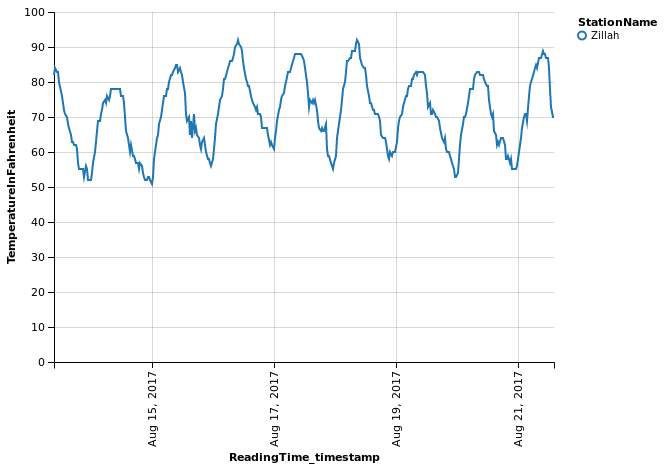

In [45]:
chart = Chart(clean_multi_wsdot_weather_df.loc[clean_multi_wsdot_weather_df['StationName'] 
                                         == 'Zillah']).mark_line().encode(
    x= 'ReadingTime_timestamp',
    y='TemperatureInFahrenheit',
    color='StationName',
)
chart


In [46]:
clean_multi_traffic_df.shape

(70998, 20)

In [47]:
import numpy as np
chosen_idx = np.random.choice(70998, replace=False, size=4000)

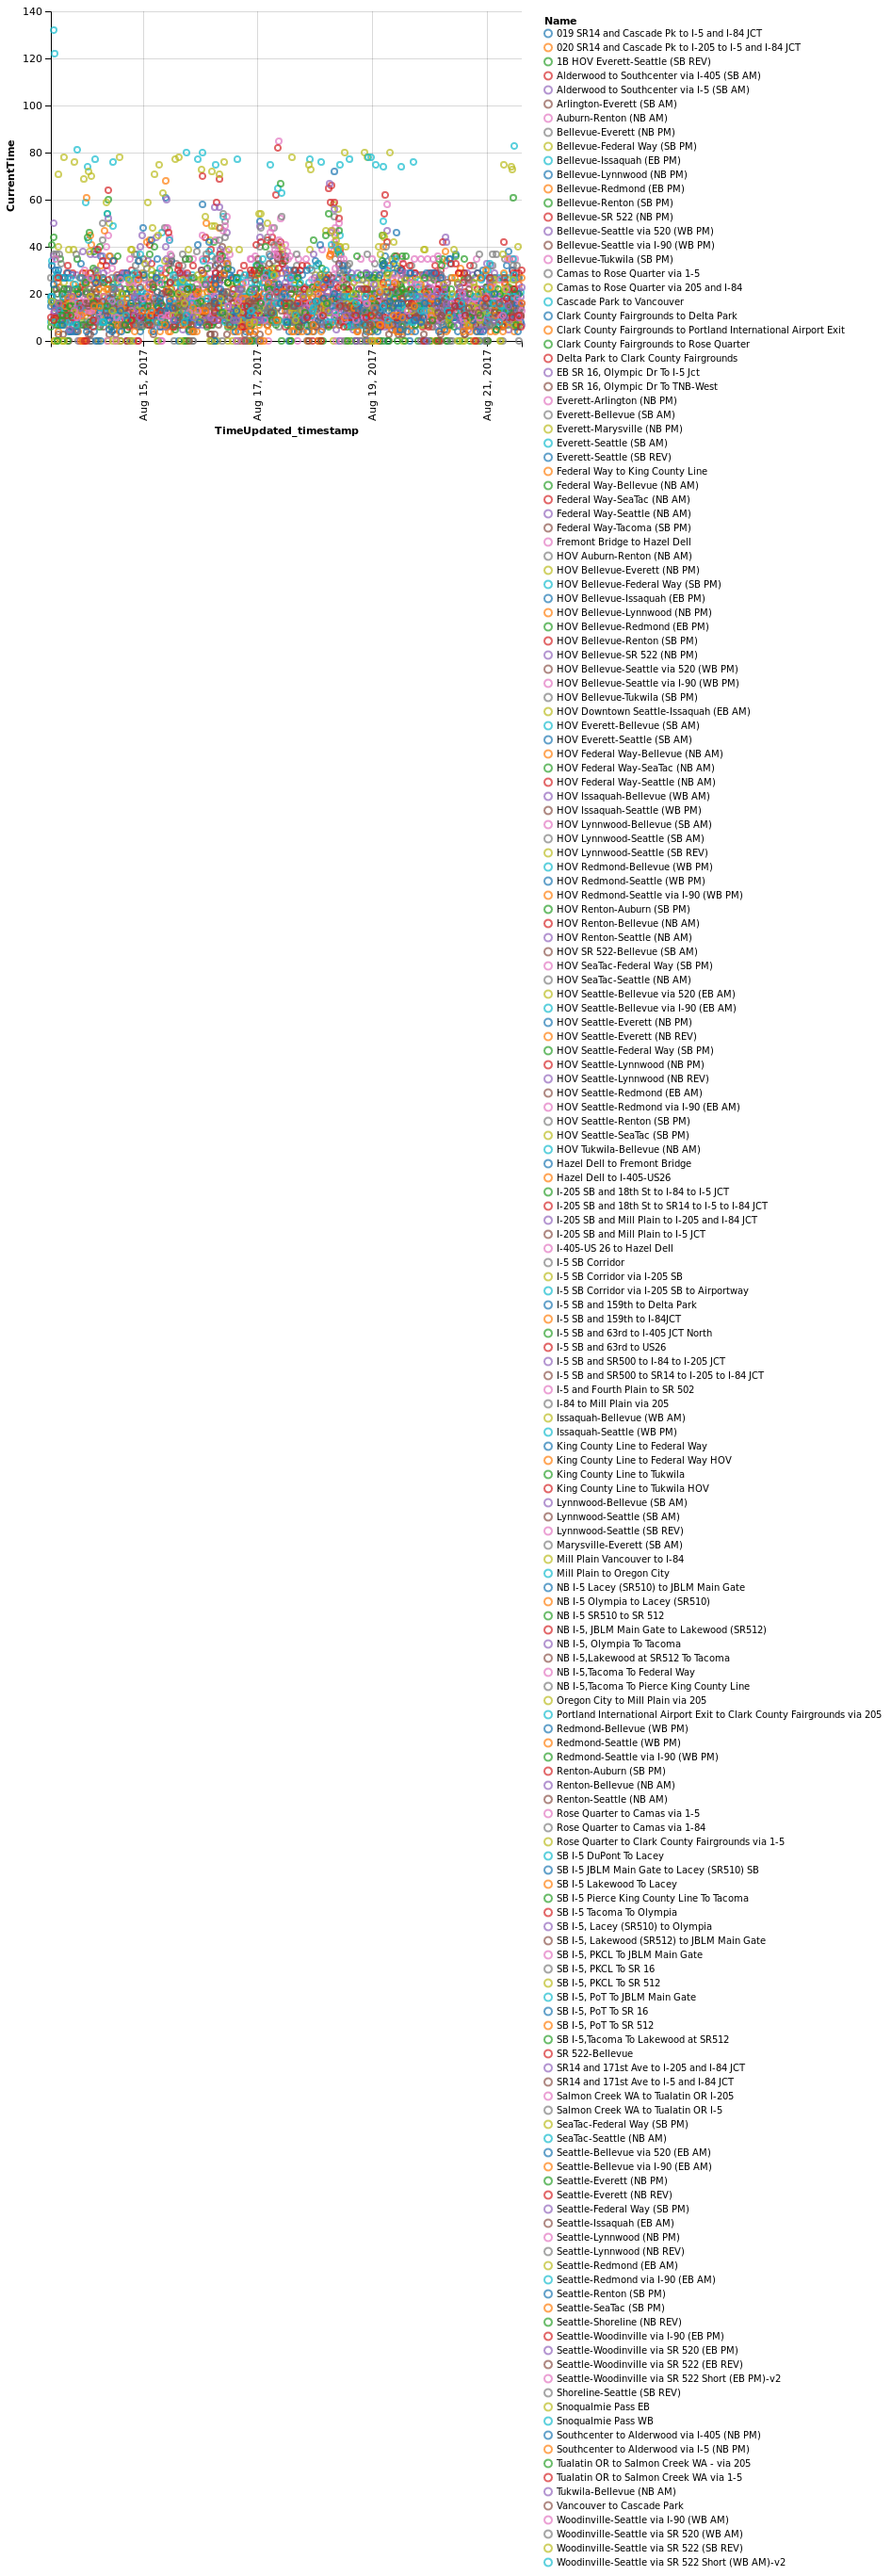

In [48]:
# NOTE: The traffic dataset is very large, so use this to start the jupyter server.
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
chart = Chart(clean_multi_traffic_df.iloc[chosen_idx]).mark_point().encode(
    x= 'TimeUpdated_timestamp',
    y='CurrentTime',
    color='Name',
)
chart

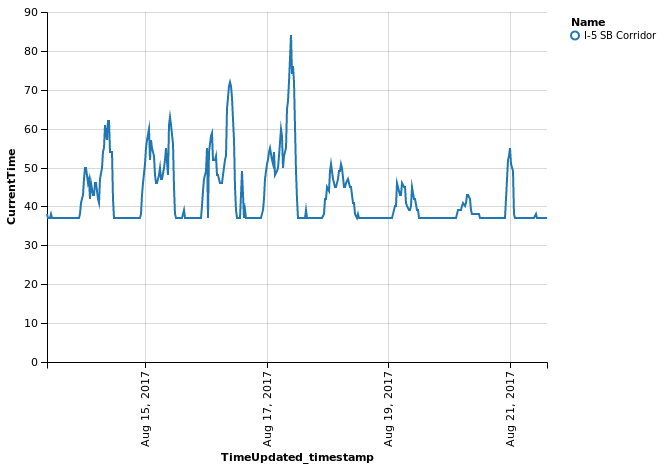

In [49]:
# NOTE: The traffic dataset is very large, so use this to start the jupyter server.
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
# Bellevue-Issaquah (EB PM)
chart = Chart(clean_multi_traffic_df.loc[clean_multi_traffic_df['Name'] 
                                         == 'I-5 SB Corridor']).mark_line().encode(
    
    x= 'TimeUpdated_timestamp',
    y='CurrentTime',
    color='Name',
)
chart

# Mapping with Folium

Start with a simple base map

In [50]:
import folium
map_osm = folium.Map(location=[46.3013, -120.3126], zoom_start=7)
map_osm.save('osm.html')
map_osm

Reload a _single_ traffic and weather json file.  Each file has the same spatial data, so it would be redundtant to plot them all. 

In [51]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize

jsondir = "/home/vagrant/json"
wsdot_traffic_filepath = jsondir + "/wsdot_traffic/2017-08-13-23-39-28"

with open(wsdot_traffic_filepath) as json_file:
  raw_json = json.load(json_file)

raw_json

wsdot_traffic_df = json_normalize(raw_json)
wsdot_traffic_df

AverageTime  CurrentTime  \
0             30           34   
1             27           28   
2             27           28   
3             11           11   
4             11           11   
5             10           10   
6             11           13   
7             26           26   
8             28           27   
9             26           26   
10            27           27   
11            17           37   
12            12           10   
13             9            9   
14             9            9   
15            33           58   
16            28           25   
17            22           23   
18            22           22   
19            27           50   
20            35           56   
21            26           33   
22            30           27   
23            16           17   
24            19           23   
25            16           18   
26             0            0   
27             0            0   
28            17           21   
29            15           14   
..           ...          ...   
150           24           25   
151           14           15   
152           13           15   
153           19           20   
154           14           15   
155           14           14   
156           38           18   
157            7            7   
158           16           16   
159           26           26   
160           23           23   
161           20           22   
162           35           37   
163           35           34   
164            8           12   
165           11           17   
166           10           11   
167           22           22   
168           16           17   
169           10           11   
170           21           21   
171           18           18   
172            9            9   
173            3            3   
174           17           17   
175            5            5   
176           11           11   
177           22           20   
178            9            8   
179           15           14   

                                           Description  Distance  \
0          Everett to Downtown Seattle using HOV lanes     26.72   
1          Downtown Seattle to Everett using HOV lanes     26.94   
2                          Downtown Seattle to Everett     26.94   
3                        Downtown Bellevue to Issaquah      9.55   
4        Downtown Bellevue to Issaquah using HOV lanes      9.55   
5        Issaquah to Downtown Bellevue using HOV lanes      9.48   
6                        Issaquah to Downtown Bellevue      9.48   
7                         Downtown Bellevue to Everett     26.06   
8                         Everett to Downtown Bellevue     26.34   
9         Downtown Bellevue to Everett using HOV lanes     26.06   
10        Everett to Downtown Bellevue using HOV lanes     26.34   
11                               Federal Way to SeaTac      8.82   
12               Federal Way to SeaTac using HOV lanes      8.82   
13               SeaTac to Federal Way using HOV lanes      9.16   
14                               SeaTac to Federal Way      9.16   
15                     Federal Way to Downtown Seattle     22.15   
16     Federal Way to Downtown Seattle using HOV lanes     22.15   
17     Downtown Seattle to Federal Way using HOV lanes     22.19   
18                     Downtown Seattle to Federal Way     22.19   
19                    Downtown Bellevue to Federal Way     24.56   
20                    Federal Way to Downtown Bellevue     23.58   
21    Downtown Bellevue to Federal Way using HOV lanes     24.56   
22    Federal Way to Downtown Bellevue using HOV lanes     23.58   
23        Downtown Seattle to Lynnwood using HOV lanes     15.73   
24                        Lynnwood to Downtown Seattle     15.23   
25                        Downtown Seattle to Lynnwood     15.73   
26   Lynnwood to Downtown Seattle using express lan...      0.00   
27    Lynnwood to Downtown Seattle using express lanes

In [52]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize

jsondir = "/home/vagrant/json"
wsdot_weather_filepath = jsondir + "/wsdot_weather/2017-08-13-23-37-10"

with open(wsdot_weather_filepath) as json_file:
  raw_json = json.load(json_file)

wsdot_weather_df = json_normalize(raw_json)
wsdot_weather_df

BarometricPressure   Latitude   Longitude PrecipitationInInches  \
0                1010.1  47.474800 -122.270400                  None   
1                1014.8  47.760633 -122.184048                  None   
2                 981.5  47.509000 -121.885000                  None   
3                1002.6  47.726000 -122.324000                  None   
4                   NaN  46.436000 -117.350000                  None   
5                   NaN  47.033800 -123.097100                  None   
6                   NaN  47.555500 -120.586600                  None   
7                   NaN  47.269100 -121.239200                  None   
8                   NaN  48.070300 -124.049000                  None   
9                   NaN  46.887000 -120.427000                  None   
10                  NaN  46.928000 -120.500000                  None   
11                  NaN  47.305082 -121.305688                  None   
12                  NaN  47.078000 -120.724000                  None   
13                  NaN  46.943000 -120.165000                  None   
14                996.5  48.688000 -122.400000                  None   
15                  NaN  47.745900 -121.089100                  None   
16               1013.7  48.992000 -122.272000                  None   
17                  NaN  47.043000 -119.916000                  None   
18                  NaN  47.085000 -119.006000                  None   
19                  NaN  47.113000 -120.786000                  None   
20                  NaN  48.050400 -122.952300                  None   
21                  NaN  48.093800 -123.278300                  None   
22                  NaN  47.443500 -121.669400                  None   
23                994.8  47.473000 -121.742000                  None   
24                  NaN  47.427000 -121.418000                  None   
25                  NaN  47.334800 -120.577100                  None   
26                  NaN  46.638000 -121.390000                  None   
27                  NaN  47.301900 -120.067800                  None   
28                  NaN  47.233100 -119.958200                  None   
29                  NaN  47.815600 -119.363000                  None   
..                  ...        ...         ...                   ...   
72                  NaN  48.876000 -117.348300                  None   
73                998.8  47.532000 -121.985000                  None   
74                987.3  46.217600 -119.748900                  None   
75                976.6  46.538500 -120.471800                  None   
76                977.4  46.538400 -120.472000                  None   
77                  NaN  46.393000 -120.241100                  None   
78                981.4  46.326600 -120.077900                  None   
79                  NaN  47.067700 -122.715800                  None   
80                874.1  48.390400 -119.879200                  None   
81                  NaN  47.858400 -122.621600                  None   
82               1015.6  48.446000 -122.432000                  None   
83               1000.2  47.916300 -122.207200                  None   
84                924.1  47.980300 -122.188000                  None   
85               1012.0  48.204200 -122.214200                  None   
86                996.1  47.813900 -121.570900                  None   
87                882.0  46.500278 -119.611667                  None   
88                  NaN  46.467063 -119.541111                  None   
89                  NaN  46.383155 -119.422786                  None   
90                  NaN  46.325574 -119.316126                  None   
91               1011.1  47.303516 -122.232946                  None   
92                605.5  46.049483 -118.495917                  None   
93               1003.0  47.830967 -122.262359                  None   
94                  NaN  46.802261 -123.007164                  None   
95                 29.9  47.640394 -122.25873

Set up the libraries we need, center the map on the average (i.e. midpoint) of our traffic data.

In [53]:
import folium
import numpy as np
from folium.plugins import MarkerCluster

lats = wsdot_traffic_df['StartPoint.Latitude']
lons = wsdot_traffic_df['StartPoint.Longitude']

map_center_lat = np.mean(lats)
map_center_lon = np.mean(lons)

map_osm = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=7)

Iterate over the traffic data, add each traffic point.

In [54]:

for index, row in wsdot_traffic_df.iterrows():
    lat = row['StartPoint.Latitude']
    lon = row['StartPoint.Longitude']
    LatLonStr = "(%f, %f)" % (lat, lon)
    
    thePopUp = "Traffic Sensor: " + row['Name'] + " " + LatLonStr
    folium.CircleMarker([lat, lon], popup=thePopUp, color='#555555', fill_color='#555555', radius=5).add_to(map_osm)


Iterate over the weather data, add each traffic point.

In [55]:

for index, row in wsdot_weather_df.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    LatLonStr = "(%f, %f)" % (lat, lon)
                              
    thePopUp = "Weather Sensor: " + row['StationName'] + " " + LatLonStr
    folium.CircleMarker([lat, lon], popup=thePopUp, color='#3186cc', fill_color='#3186cc', radius=5).add_to(map_osm)


display the map!

In [56]:
map_osm

 # Getting Weather for Portland
 
One of the main things the map teaches us, is the distribution of weather stations vs. traffic sensors.
Weather stations are distributed all thought the state; traffic sensors are clustered along the I-5 cooridor between Everett and Olympia, wieth a few more along I-90, and a cluster in Portland.

Also note the absence of weather stations in Portland.  We can fix that by pulling in JSON from another weather service.

In [57]:
!head $jsondir/yahoo_weather/2017-08-21-02-10-33

{"query":{"count":1,"created":"2017-08-21T02:10:33Z","lang":"en-US","diagnostics":{"publiclyCallable":"true","url":{"execution-start-time":"1","execution-stop-time":"5","execution-time":"4","content":"http://weather-ydn-yql.media.yahoo.com:4080/v3/public/weather/rss?w=2475687"},"user-time":"6","service-time":"4","build-version":"2.0.164"},"results":{"channel":{"units":{"distance":"mi","pressure":"in","speed":"mph","temperature":"F"},"title":"Yahoo! Weather - Portland, OR, US","link":"http://us.rd.yahoo.com/dailynews/rss/weather/Country__Country/*https://weather.yahoo.com/country/state/city-2475687/","description":"Yahoo! Weather for Portland, OR, US","language":"en-us","lastBuildDate":"Sun, 20 Aug 2017 07:10 PM PDT","ttl":"60","location":{"city":"Portland","country":"United States","region":" OR"},"wind":{"chill":"81","direction":"335","speed":"14"},"atmosphere":{"humidity":"39","pressure":"1008.0","rising":"0","visibility":"16.1"},"astronomy":{"sunrise":"6:17 am","sunset":"8:10 pm"},"

Load a sample yahoo json file

In [58]:
yahoo_weather_filepath = jsondir + "/yahoo_weather/2017-08-21-02-10-33"
yahoo_weather_folder = jsondir + "/yahoo_weather"

In [59]:
with open(yahoo_weather_filepath) as json_file:
   raw_json = json.load(json_file)

raw_json

{'query': {'count': 1,
  'created': '2017-08-21T02:10:33Z',
  'diagnostics': {'build-version': '2.0.164',
   'publiclyCallable': 'true',
   'service-time': '4',
   'url': {'content': 'http://weather-ydn-yql.media.yahoo.com:4080/v3/public/weather/rss?w=2475687',
    'execution-start-time': '1',
    'execution-stop-time': '5',
    'execution-time': '4'},
   'user-time': '6'},
  'lang': 'en-US',
  'results': {'channel': {'astronomy': {'sunrise': '6:17 am',
     'sunset': '8:10 pm'},
    'atmosphere': {'humidity': '39',
     'pressure': '1008.0',
     'rising': '0',
     'visibility': '16.1'},
    'description': 'Yahoo! Weather for Portland, OR, US',
    'image': {'height': '18',
     'link': 'http://weather.yahoo.com',
     'title': 'Yahoo! Weather',
     'url': 'http://l.yimg.com/a/i/brand/purplelogo//uh/us/news-wea.gif',
     'width': '142'},
    'item': {'condition': {'code': '30',
      'date': 'Sun, 20 Aug 2017 06:00 PM PDT',
      'temp': '80',
      'text': 'Partly Cloudy'},
     '

In [60]:
yahoo_weather_df = pd.read_json(yahoo_weather_filepath)
yahoo_weather_df

query
count                                                        1
created                                   2017-08-21T02:10:33Z
diagnostics  {'service-time': '4', 'user-time': '6', 'publi...
lang                                                     en-US
results      {'channel': {'title': 'Yahoo! Weather - Portla...

As you can see, the yahoo json is very hiearchical. Let's take a look at query.results.

In [61]:
with open(yahoo_weather_filepath) as json_file:
  raw_json = json.load(json_file)

yahoo_weather_df = json_normalize(raw_json['query']['results']) 
yahoo_weather_df

channel.astronomy.sunrise channel.astronomy.sunset  \
0                   6:17 am                  8:10 pm   

  channel.atmosphere.humidity channel.atmosphere.pressure  \
0                          39                      1008.0   

  channel.atmosphere.rising channel.atmosphere.visibility  \
0                         0                          16.1   

                   channel.description channel.image.height  \
0  Yahoo! Weather for Portland, OR, US                   18   

         channel.image.link channel.image.title        ...          \
0  http://weather.yahoo.com      Yahoo! Weather        ...           

  channel.location.region                      channel.title channel.ttl  \
0                      OR  Yahoo! Weather - Portland, OR, US          60   

  channel.units.distance channel.units.pressure channel.units.speed  \
0                     mi                     in                 mph   

  channel.units.temperature channel.wind.chill channel.wind.direction  \
0                         F                 81                    335   

  channel.wind.speed  
0                 14  

[1 rows x 39 columns]

In [62]:
yahoo_weather_df.dtypes

channel.astronomy.sunrise        object
channel.astronomy.sunset         object
channel.atmosphere.humidity      object
channel.atmosphere.pressure      object
channel.atmosphere.rising        object
channel.atmosphere.visibility    object
channel.description              object
channel.image.height             object
channel.image.link               object
channel.image.title              object
channel.image.url                object
channel.image.width              object
channel.item.condition.code      object
channel.item.condition.date      object
channel.item.condition.temp      object
channel.item.condition.text      object
channel.item.description         object
channel.item.forecast            object
channel.item.guid.isPermaLink    object
channel.item.lat                 object
channel.item.link                object
channel.item.long                object
channel.item.pubDate             object
channel.item.title               object
channel.language                 object


In [63]:
# source: https://stackoverflow.com/questions/15891038/pandas-change-data-type-of-columns
yahoo_weather_df = yahoo_weather_df.apply(pd.to_numeric, errors='ignore')
yahoo_weather_df.dtypes

channel.astronomy.sunrise         object
channel.astronomy.sunset          object
channel.atmosphere.humidity        int64
channel.atmosphere.pressure      float64
channel.atmosphere.rising          int64
channel.atmosphere.visibility    float64
channel.description               object
channel.image.height               int64
channel.image.link                object
channel.image.title               object
channel.image.url                 object
channel.image.width                int64
channel.item.condition.code        int64
channel.item.condition.date       object
channel.item.condition.temp        int64
channel.item.condition.text       object
channel.item.description          object
channel.item.forecast             object
channel.item.guid.isPermaLink     object
channel.item.lat                 float64
channel.item.link                 object
channel.item.long                float64
channel.item.pubDate              object
channel.item.title                object
channel.language

In [64]:
yahoo_weather_df['channel.item.condition.date'] = pd.to_datetime(yahoo_weather_df['channel.item.condition.date'])
yahoo_weather_df.dtypes

channel.astronomy.sunrise                object
channel.astronomy.sunset                 object
channel.atmosphere.humidity               int64
channel.atmosphere.pressure             float64
channel.atmosphere.rising                 int64
channel.atmosphere.visibility           float64
channel.description                      object
channel.image.height                      int64
channel.image.link                       object
channel.image.title                      object
channel.image.url                        object
channel.image.width                       int64
channel.item.condition.code               int64
channel.item.condition.date      datetime64[ns]
channel.item.condition.temp               int64
channel.item.condition.text              object
channel.item.description                 object
channel.item.forecast                    object
channel.item.guid.isPermaLink            object
channel.item.lat                        float64
channel.item.link                       

In [65]:
for index, row in yahoo_weather_df.iterrows():
    lat = row['channel.item.lat']
    lon = row['channel.item.long']
    LatLonStr = "(%f, %f)" % (lat, lon)
                              
    thePopUp = row['channel.title'] + " " + LatLonStr
    folium.CircleMarker([lat, lon], popup=thePopUp, color='#3186cc', fill_color='#3186cc', radius=5).add_to(map_osm)

map_osm

In [66]:
top_folder = jsondir + "/yahoo_weather"
first_time = True

for filename in os.listdir(top_folder):
    filepath = top_folder + "/" + filename

    # print ("about to read " + filename)
    with open(filepath) as json_file:
      raw_json = json.load(json_file)

    new_df = json_normalize(raw_json['query']['results'])
    
    if (first_time):
        first_time = False
        multi_yahoo_weather_df = new_df
    else:
        multi_yahoo_weather_df = multi_yahoo_weather_df.append(new_df, ignore_index=True)

multi_yahoo_weather_df = multi_yahoo_weather_df.apply(pd.to_numeric, errors='ignore')
multi_yahoo_weather_df['channel.item.condition.date'] =  pd.to_datetime(multi_yahoo_weather_df['channel.item.condition.date'])
multi_yahoo_weather_df

channel.astronomy.sunrise channel.astronomy.sunset  \
0                    6:18 am                   8:8 pm   
1                    6:18 am                   8:8 pm   
2                    6:17 am                  8:10 pm   
3                    6:18 am                   8:8 pm   
4                    6:18 am                   8:8 pm   
5                    6:18 am                   8:8 pm   
6                    6:18 am                   8:8 pm   
7                    6:18 am                   8:8 pm   
8                    6:17 am                  8:10 pm   
9                    6:18 am                   8:8 pm   
10                   6:18 am                   8:8 pm   
11                   6:18 am                   8:8 pm   
12                   6:18 am                   8:8 pm   
13                   6:18 am                   8:8 pm   
14                   6:17 am                  8:10 pm   
15                   6:17 am                  8:10 pm   
16                   6:18 am                   8:8 pm   
17                   6:18 am                   8:8 pm   
18                   6:18 am                   8:8 pm   
19                   6:18 am                   8:8 pm   
20                   6:17 am                  8:10 pm   
21                   6:18 am                   8:8 pm   
22                   6:18 am                   8:8 pm   
23                   6:18 am                   8:8 pm   
24                   6:17 am                  8:10 pm   
25                   6:18 am                   8:8 pm   
26                   6:18 am                   8:8 pm   
27                   6:18 am                   8:8 pm   
28                   6:18 am                   8:8 pm   
29                   6:18 am                   8:8 pm   
30                   6:18 am                   8:8 pm   
31                   6:17 am                  8:10 pm   
32                   6:18 am                   8:8 pm   
33                   6:18 am                   8:8 pm   
34                   6:18 am                   8:8 pm   
35                   6:17 am                  8:10 pm   
36                   6:18 am                   8:8 pm   
37                   6:18 am                   8:8 pm   
38                   6:18 am                   8:8 pm   
39                   6:18 am                   8:8 pm   
40                   6:17 am                  8:10 pm   
41                   6:18 am                   8:8 pm   
42                   6:18 am                   8:8 pm   
43                   6:18 am                   8:8 pm   
44                   6:18 am                   8:8 pm   
45                   6:18 am                   8:8 pm   
46                   6:18 am                   8:8 pm   
47                   6:18 am                   8:8 pm   
48                   6:18 am                   8:8 pm   
49                   6:17 am                  8:10 pm   
50                   6:18 am                   8:8 pm   
51                   6:18 am                   8:8 pm   
52                   6:18 am                   8:8 pm   
53                   6:17 am                  8:10 pm   

    channel.atmosphere.humidity  channel.atmosphere.pressure  \
0                            84                       1010.0   
1                            82                       1010.0   
2                            39                       1008.0   
3                            75                       1009.0   
4                            68                       1009.0   
5                            35                       1004.0   
6                            81                       1010.0   
7                            41                       1005.0   
8                            67                       1009.0   
9                            31                       1004.0   
10                           85                       1009.0   
11                           67                       1009.0   
12                           35    

In [67]:
multi_yahoo_weather_df.shape

(54, 39)

# Merging Weather Data
We have weather data from two different sources - Yahoo and WSDOT. To merge them in a meaninful way, we need to find common fields, and use them to constructe a new merged dataframe. 

From WSDOOT we have:

In [68]:
clean_multi_wsdot_weather_df.dtypes

BarometricPressure                float64
Latitude                          float64
Longitude                         float64
PrecipitationInInches              object
ReadingTime                        object
RelativeHumidity                  float64
SkyCoverage                        object
StationID                           int64
StationName                        object
TemperatureInFahrenheit           float64
Visibility                         object
WindDirection                     float64
WindDirectionCardinal              object
WindGustSpeedInMPH                float64
WindSpeedInMPH                    float64
ReadingTime_timestamp      datetime64[ns]
dtype: object

... and from Yahoo

In [69]:
multi_yahoo_weather_df.dtypes

channel.astronomy.sunrise                object
channel.astronomy.sunset                 object
channel.atmosphere.humidity               int64
channel.atmosphere.pressure             float64
channel.atmosphere.rising                 int64
channel.atmosphere.visibility           float64
channel.description                      object
channel.image.height                      int64
channel.image.link                       object
channel.image.title                      object
channel.image.url                        object
channel.image.width                       int64
channel.item.condition.code               int64
channel.item.condition.date      datetime64[ns]
channel.item.condition.temp               int64
channel.item.condition.text              object
channel.item.description                 object
channel.item.forecast                    object
channel.item.guid.isPermaLink            object
channel.item.lat                        float64
channel.item.link                       

Assembling common fields across both data frames gives us:

|WSDOT                      |Yahoo                          |
|--------------------------:|:------------------------------|
| StationName               | channel.title                 |
| Latitude                  | channel.item.lat              |
| Longitude                 | channel.item.long             |
| ReadingTime_timestamp     | channel.item.condition.date   |
| BarometricPressure        | channel.atmosphere.pressure   |
| RelativeHumidity          | channel.atmosphere.humidity   |
| TemperatureInFahrenheit   | channel.item.condition.temp   |
| WindDirection             | channel.wind.direction        |
| WindSpeedInMPH            | channel.wind.speed            |
| Visibility                | channel.atmosphere.visibility |

The Yahoo dataframe is only one row, so we'll start with that one. Select the columns we want, then rename them to match the WSDOT dataframe

In [70]:
merged_weather_df = multi_yahoo_weather_df[['channel.title', 
                                      'channel.item.lat', 
                                      'channel.item.lat',
                                      'channel.item.condition.date',
                                      'channel.atmosphere.pressure',
                                      'channel.atmosphere.humidity',
                                      'channel.item.condition.temp',
                                      'channel.wind.direction',
                                      'channel.wind.speed',
                                      'channel.atmosphere.visibility'
                                     ]]

merged_weather_df.columns = ['StationName', 
                             'Latitude', 
                             'Longitude',
                             'ReadingTime_timestamp',
                             'BarometricPressure',
                             'RelativeHumidity',
                             'TemperatureInFahrenheit',
                             'WindDirection',
                             'WindSpeedInMPH',
                             'Visibility'                             
                            ]

merged_weather_df.head()

StationName   Latitude  Longitude  \
0  Yahoo! Weather - Portland, OR, US  45.536701  45.536701   
1  Yahoo! Weather - Portland, OR, US  45.536701  45.536701   
2  Yahoo! Weather - Portland, OR, US  45.536701  45.536701   
3  Yahoo! Weather - Portland, OR, US  45.536701  45.536701   
4  Yahoo! Weather - Portland, OR, US  45.536701  45.536701   

  ReadingTime_timestamp  BarometricPressure  RelativeHumidity  \
0   2017-08-21 10:00:00              1010.0                84   
1   2017-08-21 15:00:00              1010.0                82   
2   2017-08-21 01:00:00              1008.0                39   
3   2017-08-21 08:00:00              1009.0                75   
4   2017-08-21 17:00:00              1009.0                68   

   TemperatureInFahrenheit  WindDirection  WindSpeedInMPH  Visibility  
0                       61            350               7        16.1  
1                       62              0               7        16.1  
2                       80            335              14        16.1  
3                       66            335               7        16.1  
4                       67            350              11        16.1

In [71]:
merged_weather_df = merged_weather_df.append(clean_multi_wsdot_weather_df[['StationName', 
                                                               'Latitude', 
                                                               'Longitude',
                                                               'ReadingTime_timestamp',
                                                               'BarometricPressure',
                                                               'RelativeHumidity',
                                                               'TemperatureInFahrenheit',
                                                               'WindDirection',
                                                               'WindSpeedInMPH',
                                                               'Visibility'
                                                              ]])


merged_weather_df

StationName   Latitude   Longitude  \
0      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
1      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
2      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
3      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
4      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
5      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
6      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
7      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
8      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
9      Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
10     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
11     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
12     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
13     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
14     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
15     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
16     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
17     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
18     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
19     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
20     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
21     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
22     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
23     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
24     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
25     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
26     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
27     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
28     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
29     Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
...                                  ...        ...         ...   
40901      Metaline Fall on SR31@MP16.69  48.876000 -117.348300   
40902                     I-90 at Sunset  47.532000 -121.985000   
40903                            Prosser  46.217600 -119.748900   
40904                             Parker  46.538500 -120.471800   
40905                          Union Gap  46.538400 -120.472000   
40906                             Zillah  46.393000 -120.241100   
40907                            Outlook  46.326600 -120.077900   
40908          Nisqually on I-5 @ MP 116  47.067700 -122.715800   
40909            Loup Loup Pass on SR 20  48.390400 -119.879200   
40910                  Hood Canal Bridge  47.858400 -122.621600   
40911                       MOUNT VERNON  48.446000 -122.432000   
40912                  SR526 INTERCHANGE  47.916300 -122.207200   
40913      SR2 @ I-5 INTERCHANGE EVERETT  47.980300 -122.188000   
40914                STILLIGUAMISH RIVER  48.204200 -122.214200   
40915                  INDEX GALENA ROAD  47.813900 -121.570900   
40916                     SR240 @ Beloit  46.500278 -119.611667   
40917                SR240 @ Mid Hanford  46.467063 -119.541111   
40918             SR240 @ SR225 Horn Rd   46.383155 -119.422786   
40919               SR240 @ Twin Bridges  46.325574 -119.316126   
40920               SR 18 @ C St, Auburn  47.303516 -122.232946   
40921     SR12 @ Frenchtown Rd MP 328.75  46.049483 -118.495917   
40922                       I-5 at I-405  47.830967 -122.262359   
40923                        GRAND MOUND  46.802261 -123.007164   
40924                      SR 520 Bridge  47.640394 -122.258735   
40925                SR 7 @ SR 706 Elbe   46.763143 -122.192030   
40926       SR 539 at SR 546 (Badger Rd)  48.963854 -122.484913   
40927         SR 539 at SR 544 (Pole Rd)  48.891981 -122.485690   
40928                  SR 522 at Main St  47.847409 -122.009760   
40929    

In [72]:
merged_1file_weather_df = yahoo_weather_df[['channel.title', 
                                      'channel.item.lat', 
                                      'channel.item.lat',
                                      'channel.item.condition.date',
                                      'channel.atmosphere.pressure',
                                      'channel.atmosphere.humidity',
                                      'channel.item.condition.temp',
                                      'channel.wind.direction',
                                      'channel.wind.speed',
                                      'channel.atmosphere.visibility'
                                     ]]

merged_1file_weather_df.columns = ['StationName', 
                             'Latitude', 
                             'Longitude',
                             'ReadingTime_timestamp',
                             'BarometricPressure',
                             'RelativeHumidity',
                             'TemperatureInFahrenheit',
                             'WindDirection',
                             'WindSpeedInMPH',
                             'Visibility'                             
                            ]

merged_1file_weather_df = merged_1file_weather_df.append(clean_wsdot_weather_df[['StationName', 
                                                               'Latitude', 
                                                               'Longitude',
                                                               'ReadingTime_timestamp',
                                                               'BarometricPressure',
                                                               'RelativeHumidity',
                                                               'TemperatureInFahrenheit',
                                                               'WindDirection',
                                                               'WindSpeedInMPH',
                                                               'Visibility'
                                                              ]])

merged_1file_weather_df

StationName   Latitude   Longitude  \
0    Yahoo! Weather - Portland, OR, US  45.536701   45.536701   
0                         SB I-5 144th  47.474800 -122.270400   
1                  SB I-405 N.E. 195th  47.760633 -122.184048   
2            EB I-90 @ SR-18 Echo Lake  47.509000 -121.885000   
3                         130th Street  47.726000 -122.324000   
4                        Alpowa Summit  46.436000 -117.350000   
5                  Rock Candy Mountain  47.033800 -123.097100   
6                          Dryden Road  47.555500 -120.586600   
7                          Easton Hill  47.269100 -121.239200   
8                     Heckelville Shed  48.070300 -124.049000   
9            Manastash Ridge Eastbound  46.887000 -120.427000   
10           Manastash Ridge Westbound  46.928000 -120.500000   
11                   Stampede Overpass  47.305082 -121.305688   
12                        Rocky Canyon  47.078000 -120.724000   
13                     Ryegrass Summit  46.943000 -120.165000   
14           Lake Samish Park and Ride  48.688000 -122.400000   
15                        Stevens Pass  47.745900 -121.089100   
16     SUMAS SR 9 AT FRONT ST (SR 547)  48.992000 -122.272000   
17                         Silica Road  47.043000 -119.916000   
18                  Warden Interchange  47.085000 -119.006000   
19                         Elk Heights  47.113000 -120.786000   
20                       Diamond Point  48.050400 -122.952300   
21                Seibert Creek Bridge  48.093800 -123.278300   
22             Snoqualmie River Bridge  47.443500 -121.669400   
23        WB I-90 near Tanner Crossing  47.473000 -121.742000   
24                       Alpental Exit  47.427000 -121.418000   
25                        Blewett Pass  47.334800 -120.577100   
26                   White Pass Summit  46.638000 -121.390000   
27                           Palisades  47.301900 -120.067800   
28                    Quincy Rest Area  47.233100 -119.958200   
..                                 ...        ...         ...   
72       Metaline Fall on SR31@MP16.69  48.876000 -117.348300   
73                      I-90 at Sunset  47.532000 -121.985000   
74                             Prosser  46.217600 -119.748900   
75                              Parker  46.538500 -120.471800   
76                           Union Gap  46.538400 -120.472000   
77                              Zillah  46.393000 -120.241100   
78                             Outlook  46.326600 -120.077900   
79           Nisqually on I-5 @ MP 116  47.067700 -122.715800   
80             Loup Loup Pass on SR 20  48.390400 -119.879200   
81                   Hood Canal Bridge  47.858400 -122.621600   
82                        MOUNT VERNON  48.446000 -122.432000   
83                   SR526 INTERCHANGE  47.916300 -122.207200   
84       SR2 @ I-5 INTERCHANGE EVERETT  47.980300 -122.188000   
85                 STILLIGUAMISH RIVER  48.204200 -122.214200   
86                   INDEX GALENA ROAD  47.813900 -121.570900   
87                      SR240 @ Beloit  46.500278 -119.611667   
88                 SR240 @ Mid Hanford  46.467063 -119.541111   
89              SR240 @ SR225 Horn Rd   46.383155 -119.422786   
90                SR240 @ Twin Bridges  46.325574 -119.316126   
91                SR 18 @ C St, Auburn  47.303516 -122.232946   
92      SR12 @ Frenchtown Rd MP 328.75  46.049483 -118.495917   
93                        I-5 at I-405  47.830967 -122.262359   
94                         GRAND MOUND  46.802261 -123.007164   
95                       SR 520 Bridge  47.640394 -122.258735   
96                 SR 7 @ SR 706 Elbe   46.763143 -122.192030   
97        SR 539 at SR 546 (Badger Rd)  48.963854 -122.484913   
98          SR 539 at SR 544 (Pole Rd)  48.891981 -122.485690   
99                   SR 522 at Main St  47.847409 -122.009760   
100               SR 167 at S 277th St  47.353395 -122.244567   
101              Tacoma Narrows Bridge  47.263826 -122.545658 

# Merging Traffic  and Weather

We want to make a dataframe in which each row has traffic and weather data. We learned from mapping, that the traffic points are clustered on a few major freeways (I-5), while the weather points are scattered across the state. In order to make a meaninful data frame, each row will have the data from ne row out of the traffic dataframe, _plus_ the weather coluns from a weather dataframe row that has a _similar_ position and time stamp.  In other words, each row shall have 

- Traffic conditions at a specfic location, date, and time
- Weather conditions from  a _nearby_ weather station at a _simlar_ date and time

## Merging Traffic and Weather, pseudo code

## Function to filter by spatial bounding box

In [73]:
# ----------------------------------------------------------------------
# FUNCTION: filter_by_bbox
#   inputs: dataframe, columns names, coordinates, boundgin box size.
#  outputs: new dataframe, containing only those rows whos latitude and longitude fit within the bbox.
# ----------------------------------------------------------------------

import pandas as pd

def filter_by_bbox(df, LATcolumn, LONcolumn, LATvalue, LONvalue, BBoxSize):
    # Set up the bbox variables
    lat_sml_enough = df[LATcolumn] <= LATvalue + BBoxSize
    lat_big_enough = df[LATcolumn] >= LATvalue - BBoxSize
    lon_sml_enough = df[LONcolumn] <= LONvalue + BBoxSize
    lon_big_enough = df[LONcolumn] >= LONvalue - BBoxSize

    return df[lat_sml_enough & lat_big_enough & lon_sml_enough & lon_big_enough]

## Testing the Spatial  Filter Function

Grab the location data form the first row of the cleaned WSDOT traffic data frame. 

In [74]:
FilterLat = clean_multi_traffic_df['EndPoint.Latitude'].iloc[0]
FilterLon = clean_multi_traffic_df['EndPoint.Longitude'].iloc[0]

print (FilterLat)
print (FilterLon)

47.609294
-122.331759


Filter the dataframe for rows that are within 0.2 degrees of the first rrow.
Print the row-count of the result

In [75]:
filtered_wsdot_draffic_df  = filter_by_bbox(clean_multi_traffic_df, 
                                            'EndPoint.Latitude', 
                                            'EndPoint.Longitude',
                                          FilterLat, FilterLon,
                                           0.2)
len (filtered_wsdot_draffic_df.index)

28440

Compare the rowcount of the original dataframe

In [76]:
len(clean_multi_traffic_df.index)

70998

## Function to filter by timesamp

In [77]:
# ----------------------------------------------------------------------
# FUNCTION: filter_by_datetime
#   inputs: dataframe, name of datetime column, datetime value, 
#           optional args for timebox size in weeks, days, hours, minutes, second.
#  outputs: new dataframe, containing only those rows whos timesamp fits within the delta
# ----------------------------------------------------------------------
import pandas as pd
import datetime as dt

def filter_by_datetime(df, dt_column, dt_value,
                       delta_weeks=0, 
                       delta_days=0, 
                       delta_hours=0, 
                       delta_minutes=0, 
                       delta_seconds=0):

    timebox_upper = dt_value + dt.timedelta(weeks   = delta_weeks, 
                                                days    = delta_days,
                                                hours   = delta_hours,
                                                minutes = delta_minutes,
                                                seconds = delta_seconds)

    timebox_lower = dt_value - dt.timedelta(weeks   = delta_weeks, 
                                                days    = delta_days,
                                                hours   = delta_hours,
                                                minutes = delta_minutes,
                                                seconds = delta_seconds)

    within_timebox_upper = df[dt_column] <= timebox_upper
    within_timebox_lower = df[dt_column] >= timebox_lower
    
    return df[within_timebox_upper & within_timebox_lower]

## Testing the timesamp  Filter Function

Grab the timestamp form the first row of the Merged Weather dataframe (i.e. the onw with WSDOT and Yahoo weather in it.)

In [78]:
time1 = merged_weather_df['ReadingTime_timestamp'].iloc[0]
time1

Timestamp('2017-08-21 10:00:00')

Filter the dataframe for rows that occured in the same hour. Print the row-count of the result

In [79]:
timefiltered_weather = filter_by_datetime(merged_weather_df, 'ReadingTime_timestamp', time1, delta_hours=1)
len(timefiltered_weather.index)

408

Compare to the unfiltered record counts.

In [80]:
len(merged_weather_df.index)

40985

# Doing the Actual merge

In [81]:
clean_multi_traffic_df.dtypes

AverageTime                        int64
CurrentTime                        int64
Description                       object
Distance                         float64
EndPoint.Description              object
EndPoint.Direction                object
EndPoint.Latitude                float64
EndPoint.Longitude               float64
EndPoint.MilePost                float64
EndPoint.RoadName                 object
Name                              object
StartPoint.Description            object
StartPoint.Direction              object
StartPoint.Latitude              float64
StartPoint.Longitude             float64
StartPoint.MilePost              float64
StartPoint.RoadName               object
TimeUpdated                       object
TravelTimeID                       int64
TimeUpdated_timestamp     datetime64[ns]
dtype: object

In [82]:
merged_weather_df.dtypes

StationName                        object
Latitude                          float64
Longitude                         float64
ReadingTime_timestamp      datetime64[ns]
BarometricPressure                float64
RelativeHumidity                  float64
TemperatureInFahrenheit           float64
WindDirection                     float64
WindSpeedInMPH                    float64
Visibility                         object
dtype: object

In [83]:
clean_wsdot_traffic_df.dtypes

AverageTime                        int64
CurrentTime                        int64
Description                       object
Distance                         float64
EndPoint.Description              object
EndPoint.Direction                object
EndPoint.Latitude                float64
EndPoint.Longitude               float64
EndPoint.MilePost                float64
EndPoint.RoadName                 object
Name                              object
StartPoint.Description            object
StartPoint.Direction              object
StartPoint.Latitude              float64
StartPoint.Longitude             float64
StartPoint.MilePost              float64
StartPoint.RoadName               object
TimeUpdated                       object
TravelTimeID                       int64
TimeUpdated_timestamp     datetime64[ns]
dtype: object

In [84]:
found_records = 0

# Iterate over the traffic rows
for index, row in clean_wsdot_traffic_df.iterrows():
    # gather some variables
    rowLat = row['StartPoint.Latitude']
    rowLon = row['StartPoint.Longitude']
    rowDateTime = row['TimeUpdated_timestamp']
    
    # find nearby weather readings
    nearby_weather  = filter_by_bbox(merged_weather_df, 'Latitude', 'Longitude', rowLat, rowLon, 0.2)
    
    # of the neraby readings, find thos which happened within 4 hours of the traffic data
    near_and_sametime_weather = filter_by_datetime(nearby_weather, 'ReadingTime_timestamp', rowDateTime, delta_minutes=15)
    
    records_found = len(near_and_sametime_weather.index)
    if (records_found > 0):
        print (records_found)
        found_records = found_records + 1
        
print ("-------")
print (len(clean_wsdot_traffic_df.index))
print (found_records)

# Dial in the timebox
# 0.2 deg; 4 hours 135 of 180, 30's 10's, 20's
# 0.2 deg; 1 hours 135 of 180, 4's 8's, 12's
# 0.2 deg; 30 min 135 of 180, 4's 8's, 12's
# 0.2 deg; 5 min 124 of 180, 2's and 3's
# 0.2 deg; 10 min 134 of 180, 2's and 3's
# 0.2 deg; 15 min 135 of 180, 2's and 5's

# 2's ad 5's pretty good; no need to dial in further on spatial sid.

    

6
4
4
4
4
2
2
4
6
4
6
5
5
5
5
5
5
4
4
4
5
4
5
4
7
4
7
7
6
4
6
4
6
4
4
8
8
6
6
5
4
5
4
7
7
6
6
4
8
8
8
8
4
4
6
5
5
6
6
2
4
2
4
8
4
8
4
8
4
8
4
4
4
4
4
4
4
4
4
4
4
8
8
3
3
1
2
1
1
3
5
1
4
4
4
4
4
6
7
4
4
6
6
4
3
6
6
4
4
4
8
8
6
5
5
4
4
5
2
2
1
5
4
5
5
5
5
1
1
5
5
5
4
4
4
-------
180
135


In [85]:
first_time = True
processed_rows = 0
processed_thousands = 0

# Iterate over the traffic rows from a single wsdot json file.
for index, traffic_onefile_row in clean_wsdot_traffic_df.iterrows():
    # Each row has a unigue location
    
    # Select rows from multi-file traffic,  based on TravelTimeID
    theTravelTimeID = traffic_onefile_row['TravelTimeID']
    filtered_traffic_byTravelTimeID_df = clean_multi_traffic_df.loc[
            clean_multi_traffic_df['TravelTimeID'] == theTravelTimeID]
    
    # Now we have filtered_traffic_byTravelTimeID_df, 
    # a bunch of traffic rows, all same location but different datetime 
    
    # Filter the weather data by spatial bbox, based on the traffic data
    rowLat = traffic_onefile_row['StartPoint.Latitude']
    rowLon = traffic_onefile_row['StartPoint.Longitude']
    bbox_halfsize_degrees = 0.2
    
    nearby_weather_df  = filter_by_bbox(merged_weather_df, 'Latitude', 'Longitude', 
                                     rowLat, rowLon, bbox_halfsize_degrees)
    
    # print(nearby_weather_df)
   
    # Now we have nearby_weather_df, a collection of weather records, both form WSDOT and Yahoo,
    # in roughly the same location as the current traffic row.

    # fastest way to get a record count
    # source: https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
    records_found = nearby_weather_df.shape[0]
    
    if (records_found > 0):
        # Now you have a bunch of weather records and traffic records in the same location, but both
        # vary by time
        
        # iterate over the selected traffic records
        for i2, filtered_traffic_row in filtered_traffic_byTravelTimeID_df.iterrows():
            # Find weather records in the same timeframe
            
            rowDateTime = filtered_traffic_row['TimeUpdated_timestamp']
            
            # Of the nearby readings, find those which happened within 15 minutes of the traffic data
            near_and_sametime_weather_df = filter_by_datetime(nearby_weather_df, 
                                                           'ReadingTime_timestamp', 
                                                           rowDateTime, delta_minutes=15)            
     
            # Now we have near_and_sametime_weather_df, a set of weather data which aligns to the 
            # same space and time as the crrent traffic row
             
            # fastest way to get a record count
            # source: https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
            weather_records_found = near_and_sametime_weather_df.shape[0]
                 
            # If we found any records, grab the first one and make a new dataframe
            if (weather_records_found > 0):
              
                weather_1row_df = near_and_sametime_weather_df.iloc[[0]].reset_index(drop=True)
                traffic_1row_df = pd.DataFrame([filtered_traffic_row]).reset_index(drop=True)
                  
                if (first_time):
                    first_time = False
                    # source: https://pandas.pydata.org/pandas-docs/stable/merging.html
                    merged_traffic_weather_df = pd.concat([traffic_1row_df, weather_1row_df], 
                                                          axis=1, join_axes=[traffic_1row_df.index])


                else:
                    new_merged_row_df = pd.concat([traffic_1row_df, weather_1row_df], 
                                                          axis=1, join_axes=[traffic_1row_df.index])

                    merged_traffic_weather_df = merged_traffic_weather_df.append(new_merged_row_df)
                                                    
                processed_rows = processed_rows + 1
                                    
                if (processed_rows == 1000):
                    processed_thousands = processed_thousands + 1
                    processed_rows = 0
                    print(processed_thousands)
        
merged_traffic_weather_df

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


AverageTime  CurrentTime                                  Description  \
0            43           46  Everett to Downtown Seattle using HOV lanes   
0            45           49  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            48           40  Everett to Downtown Seattle using HOV lanes   
0            53           50  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            28           27  Everett to Downtown Seattle using HOV lanes   
0            56           66  Everett to Downtown Seattle using HOV lanes   
0            28           27  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            28           28  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            50           46  Everett to Downtown Seattle using HOV lanes   
0            30           32  Everett to Downtown Seattle using HOV lanes   
0            35           34  Everett to Downtown Seattle using HOV lanes   
0            30           31  Everett to Downtown Seattle using HOV lanes   
0            28           27  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            32           34  Everett to Downtown Seattle using HOV lanes   
0            39           39  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            44           46  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            38           46  Everett to Downtown Seattle using HOV lanes   
0            30           27  Everett to Downtown Seattle using HOV lanes   
0            41           39  Everett to Downtown Seattle using HOV lanes   
0            37           36  Everett to Downtown Seattle using HOV lanes   
0            28           27  Everett to Downtown Seattle using HOV lanes   
0            27           27  Everett to Downtown Seattle using HOV lanes   
0            33           31  Everett to Downtown Seattle using HOV lanes   
..          ...          ...                                          ...   
0            13           13     SB I-5 Pierce King County Line To SR 512   
0            13           12     SB I-5 Pierce King County Line To SR 512   
0            28           30     SB I-5 Pierce King County Line To SR 512   
0            25           25     SB I-5 Pierce King County Line To SR 512   
0            14           13     SB I-5 Pierce King County Line To SR 512   
0            19           23     SB I-5 Pierce King County Line To SR 512   
0            13           12     SB I-5 Pierce King County Line To SR 512   
0            15           18     SB I-5 Pierce King County Line To SR 512   
0            20           18     SB I-5 Pierce King County Line To SR 512   
0            17           12     SB I-5 Pierce King County Line To SR 512   
0            20           23     SB I-5 Pierce King County Line To SR 512   
0            13           13     SB I-5 Pierce King County Line To SR 512   
0            13           12     SB I-5 Pierce King County Line To SR 512   
0            13           12     SB I-5 Pierce King County Line To SR 512   
0            27           24     SB I-5 Pierce King County Line To SR 512   
0            23           37     SB I-5 Pierce King County Line To SR 512   
0            24           26     SB I-5 Pierce King County Line To SR 512   
0            13           12     SB I-5 Pierce King County Line To SR 512   
0            25           22     SB I-5 Pierce King County Line To SR 512   
0            13           12     SB I-5 Pierce King County Line To SR 512   


In [86]:
merged_traffic_weather_df.shape

(52975, 30)

In [87]:
merged_traffic_weather_df.dtypes

AverageTime                         int64
CurrentTime                         int64
Description                        object
Distance                          float64
EndPoint.Description               object
EndPoint.Direction                 object
EndPoint.Latitude                 float64
EndPoint.Longitude                float64
EndPoint.MilePost                 float64
EndPoint.RoadName                  object
Name                               object
StartPoint.Description             object
StartPoint.Direction               object
StartPoint.Latitude               float64
StartPoint.Longitude              float64
StartPoint.MilePost               float64
StartPoint.RoadName                object
TimeUpdated                        object
TravelTimeID                        int64
TimeUpdated_timestamp      datetime64[ns]
StationName                        object
Latitude                          float64
Longitude                         float64
ReadingTime_timestamp      datetim

In [88]:
merged_traffic_weather_df.describe()

AverageTime   CurrentTime      Distance  EndPoint.Latitude  \
count  52975.000000  52975.000000  52975.000000       52975.000000   
mean      17.074563     17.193771     14.266900          47.539409   
std       12.479495     12.720519     10.221312           0.241276   
min        0.000000      0.000000      0.000000          45.525600   
25%       10.000000     10.000000      9.160000          47.334789   
50%       14.000000     14.000000     13.220000          47.609294   
75%       22.000000     22.000000     17.220000          47.613800   
max       78.000000    136.000000     78.560000          48.152323   

       EndPoint.Longitude  EndPoint.MilePost  StartPoint.Latitude  \
count        52975.000000       52975.000000         52975.000000   
mean          -122.278633         100.559988            47.542048   
std              0.198895          72.298429             0.236383   
min           -122.891484           0.110000            45.580300   
25%           -122.331759          13.600000            47.334789   
50%           -122.269470         132.910000            47.609294   
75%           -122.188920         165.830000            47.613800   
max           -120.599140         302.170000            48.152323   

       StartPoint.Longitude  StartPoint.MilePost  TravelTimeID      Latitude  \
count          52975.000000         52975.000000  52975.000000  52975.000000   
mean            -122.271978           100.772483    124.229070     47.496421   
std                0.198189            72.036815    120.398769      0.193569   
min             -122.891484             0.110000      1.000000     45.569000   
25%             -122.331759            13.600000     34.000000     47.474800   
50%             -122.269470           136.740000     77.000000     47.474800   
75%             -122.188920           165.830000    266.000000     47.509000   
max             -120.540695           205.870000    403.000000     48.204200   

          Longitude  BarometricPressure  RelativeHumidity  \
count  52975.000000        45720.000000      50403.000000   
mean    -122.255101         1007.520448         63.413309   
std        0.206687           62.432078         17.089769   
min     -123.033100           29.900000          1.000000   
25%     -122.270400         1009.900000         51.000000   
50%     -122.270400         1013.700000         63.000000   
75%     -122.232946         1015.400000         77.000000   
max     -120.427000         1022.700000        100.000000   

       TemperatureInFahrenheit  WindDirection  WindSpeedInMPH  
count             50845.000000   52844.000000    52844.000000  
mean                 66.010325     207.320263        3.146109  
std                   7.390346     128.307316        2.457561  
min                  46.000000       0.000000        0.000000  
25%                  61.000000      85.000000        1.000000  
50%                  66.000000     245.000000        3.000000  
75%                  72.000000     325.000000        4.000000  
max                  86.000000     360.000000       23.000000

In [89]:
merged_traffic_weather_df[['AverageTime',
                    'CurrentTime',
                    'BarometricPressure',
                    'RelativeHumidity',
                    'TemperatureInFahrenheit',
                    'WindDirection',
                    'WindSpeedInMPH'
                    ]].describe()

AverageTime   CurrentTime  BarometricPressure  RelativeHumidity  \
count  52975.000000  52975.000000        45720.000000      50403.000000   
mean      17.074563     17.193771         1007.520448         63.413309   
std       12.479495     12.720519           62.432078         17.089769   
min        0.000000      0.000000           29.900000          1.000000   
25%       10.000000     10.000000         1009.900000         51.000000   
50%       14.000000     14.000000         1013.700000         63.000000   
75%       22.000000     22.000000         1015.400000         77.000000   
max       78.000000    136.000000         1022.700000        100.000000   

       TemperatureInFahrenheit  WindDirection  WindSpeedInMPH  
count             50845.000000   52844.000000    52844.000000  
mean                 66.010325     207.320263        3.146109  
std                   7.390346     128.307316        2.457561  
min                  46.000000       0.000000        0.000000  
25%                  61.000000      85.000000        1.000000  
50%                  66.000000     245.000000        3.000000  
75%                  72.000000     325.000000        4.000000  
max                  86.000000     360.000000       23.000000

In [90]:
import numpy as np
chosen_idx = np.random.choice(52975, replace=False, size=2500)
# chosen_idx = np.random.choice(2752, replace=False, size=2752)
mini_df = merged_traffic_weather_df.iloc[chosen_idx]
mini_df2 = mini_df[['StationName',
                    'AverageTime',
                    'CurrentTime',
                    'Distance',
                    'EndPoint.Latitude',
                    'EndPoint.Longitude',
                    'EndPoint.MilePost',
                    'StartPoint.Latitude',
                    'StartPoint.Longitude',
                    'StartPoint.MilePost',
                    'Latitude',
                    'Longitude',
                    'BarometricPressure',
                    'RelativeHumidity',
                    'TemperatureInFahrenheit',
                    'WindDirection',
                    'WindSpeedInMPH'
                    ]]

In [91]:
mini_df2.describe()

AverageTime  CurrentTime     Distance  EndPoint.Latitude  \
count  2500.000000  2500.000000  2500.000000        2500.000000   
mean     16.861200    16.941600    14.074484          47.533409   
std      12.219954    12.439489    10.012230           0.247152   
min       0.000000     0.000000     0.000000          45.525600   
25%       9.000000     9.000000     9.100000          47.334789   
50%      15.000000    14.000000    13.100000          47.609294   
75%      22.000000    22.000000    16.200000          47.613800   
max      78.000000    84.000000    78.560000          48.152323   

       EndPoint.Longitude  EndPoint.MilePost  StartPoint.Latitude  \
count         2500.000000        2500.000000          2500.000000   
mean          -122.283789         102.438048            47.534675   
std              0.204675          71.701670             0.239431   
min           -122.891484           0.110000            45.580300   
25%           -122.331759          13.600000            47.334789   
50%           -122.279109         134.090000            47.609294   
75%           -122.188920         165.830000            47.613800   
max           -120.599140         302.170000            48.152323   

       StartPoint.Longitude  StartPoint.MilePost     Latitude    Longitude  \
count           2500.000000          2500.000000  2500.000000  2500.000000   
mean            -122.276745           100.934328    47.487892  -122.259833   
std                0.192168            71.868052     0.195410     0.200969   
min             -122.891484             0.110000    45.569000  -123.033100   
25%             -122.331759            13.600000    47.474800  -122.270400   
50%             -122.285137           136.740000    47.474800  -122.270400   
75%             -122.188920           165.830000    47.474800  -122.232946   
max             -120.540695           205.870000    47.980300  -120.427000   

       BarometricPressure  RelativeHumidity  TemperatureInFahrenheit  \
count         2137.000000       2376.000000              2392.000000   
mean          1008.085868         63.333333                66.019231   
std             57.055443         17.083769                 7.453217   
min             30.000000          1.000000                46.000000   
25%           1009.900000         51.000000                61.000000   
50%           1013.600000         63.000000                66.000000   
75%           1015.300000         77.000000                72.000000   
max           1021.400000         99.000000                83.000000   

       WindDirection  WindSpeedInMPH  
count    2493.000000     2493.000000  
mean      211.973927        3.198556  
std       127.524541        2.492421  
min         0.000000        0.000000  
25%        95.000000        1.000000  
50%       260.000000        3.000000  
75%       325.000000        4.000000  
max       360.000000       18.000000

In [92]:
mini_df3 = mini_df2.dropna(how='any')
mini_df3.describe()

AverageTime  CurrentTime     Distance  EndPoint.Latitude  \
count  2103.000000  2103.000000  2103.000000        2103.000000   
mean     17.082263    17.067523    14.204413          47.569343   
std      11.562365    11.790238     9.127310           0.210759   
min       0.000000     0.000000     0.000000          47.011288   
25%      10.000000    10.000000     9.480000          47.463303   
50%      15.000000    15.000000    13.330000          47.609294   
75%      22.000000    22.000000    17.220000          47.613800   
max      78.000000    84.000000    74.900000          48.152323   

       EndPoint.Longitude  EndPoint.MilePost  StartPoint.Latitude  \
count         2103.000000        2103.000000          2103.000000   
mean          -122.257030         103.584917            47.575650   
std              0.183833          73.108741             0.195073   
min           -122.759508           0.110000            47.229950   
25%           -122.331759          13.600000            47.458000   
50%           -122.265700         143.640000            47.609294   
75%           -122.188920         165.830000            47.613800   
max           -120.599140         205.870000            48.152323   

       StartPoint.Longitude  StartPoint.MilePost     Latitude    Longitude  \
count           2103.000000          2103.000000  2103.000000  2103.000000   
mean            -122.252984           100.877190    47.524708  -122.229324   
std                0.096919            74.025876     0.144867     0.086008   
min             -122.442040             0.110000    47.303516  -122.324000   
25%             -122.331759            13.600000    47.474800  -122.270400   
50%             -122.265480           139.410000    47.474800  -122.270400   
75%             -122.188920           165.830000    47.509000  -122.184048   
max             -121.751422           205.870000    47.980300  -121.885000   

       BarometricPressure  RelativeHumidity  TemperatureInFahrenheit  \
count         2103.000000       2103.000000              2103.000000   
mean          1008.126201         63.351878                65.878269   
std             57.513549         17.006094                 7.455955   
min             30.000000          1.000000                46.000000   
25%           1010.000000         51.000000                60.500000   
50%           1013.700000         63.000000                65.000000   
75%           1015.300000         77.000000                72.000000   
max           1021.400000         98.000000                83.000000   

       WindDirection  WindSpeedInMPH  
count    2103.000000     2103.000000  
mean      214.429862        3.151688  
std       128.223994        2.486176  
min         0.000000        0.000000  
25%        92.500000        1.000000  
50%       275.000000        3.000000  
75%       330.000000        4.000000  
max       355.000000       11.000000

In [93]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(mini_df2, hue="StationName")


/home/vagrant/anaconda3/envs/geopandas_pip_altiair/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/vagrant/anaconda3/envs/geopandas_pip_altiair/lib/python3.5/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


In [94]:
# something interesting in the last 5x5 columns
mini_df4 = mini_df[['StationName',
                    'AverageTime',
                    'CurrentTime',
                    'BarometricPressure',
                    'RelativeHumidity',
                    'TemperatureInFahrenheit',
                    'WindDirection',
                    'WindSpeedInMPH'
                    ]]

sns.pairplot(mini_df4, hue="StationName")

/home/vagrant/anaconda3/envs/geopandas_pip_altiair/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/vagrant/anaconda3/envs/geopandas_pip_altiair/lib/python3.5/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
